# Importing Necessary Libraries

In [1]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score

from sklearn.linear_model import BayesianRidge, Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

plt.style.use("seaborn-notebook")

pd.set_option("display.max_columns", None)

### Helper Function

In [3]:
# Count, Median, Mean plot
def CMMPlot(data, col, target):
    
    df = data.copy()
    count = df.groupby(col, dropna=False, as_index=False)[target].count()
    count[col] = count[col].fillna("--")
    count = count.sort_values(by=target)
    
    means = df.groupby(col, dropna=False)[target].mean().sort_values()
    means.index = means.index.fillna("--")
    
    medians = df.groupby(col, dropna=False)[target].median().sort_values()
    medians.index = medians.index.fillna("--")
    
    means = means.reindex(medians.index)
    
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 2)
    
    plt.subplot(1, 2, 1)
    plt.barh(count[col], count[target])
    plt.xlabel("count")
    plt.ylabel(col)
    
    plt.subplot(1, 2, 2)
    plt.plot(medians, label="median")
    plt.plot(means, label="means")
    plt.xticks(rotation=90)
    plt.xlabel(col)
    plt.ylabel(target)
    plt.legend(loc="best")
    
    plt.show()
    
    return medians, means

# Loading Data

In [4]:
train_path = "train.csv"
test_path = "test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [5]:
train_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [6]:
test_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
2         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
3         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
4         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     1Story            5            6       1961   
1       Norm     1Fam     1Story            6            6       1958   
2       Norm     1Fam     2Story            5            5       1997   
3       Norm     1Fam     2Story            6            6       1998   
4       Norm   TwnhsE     1Story            8            5       1992   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          1961     Gable  CompShg     VinylSd     VinylSd       None   
1          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
2          1998     Gable  CompShg     VinylSd     VinylSd       None   
3          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4          1992     Gable  CompShg     HdBoard     HdBoard       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0         0.0        TA        TA     CBlock       TA       TA           No   
1       108.0        TA        TA     CBlock       TA       TA           No   
2         0.0        TA        TA      PConc       Gd       TA           No   
3        20.0        TA        TA      PConc       TA       TA           No   
4         0.0        Gd        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          Rec       468.0          LwQ       144.0      270.0        882.0   
1          ALQ       923.0          Unf         0.0      406.0       1329.0   
2          GLQ       791.0          Unf         0.0      137.0        928.0   
3          GLQ       602.0          Unf         0.0      324.0        926.0   
4          ALQ       263.0          Unf         0.0     1017.0       1280.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        TA          Y      SBrkr       896         0             0   
1    GasA        TA          Y      SBrkr      1329         0             0   
2    GasA        Gd          Y      SBrkr       928       701             0   
3    GasA        Ex          Y      SBrkr       926       678             0   
4    GasA        Ex          Y      SBrkr      1280         0             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0        896           0.0           0.0         1         0             2   
1       1329           0.0           0.0         1         1             3   
2       1629           0.0           0.0         2         1             3   
3       1604           0.0           0.0         2         1             3   
4       1280           0.0           0.0         2         0             2   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          TA             5        Typ           0         NaN   
1             1          Gd             6        Typ           0         NaN   
2             1          TA             6        Typ           1          TA   
3             1          Gd  

In [7]:
months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
          7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

In [8]:
train_df["MoSold"] = train_df["MoSold"].map(months)
test_df["MoSold"] = test_df["MoSold"].map(months)

In [9]:
# MSSubClass is a categorical column, not numeric 
train_df["MSSubClass"] = train_df["MSSubClass"].astype(str)
test_df["MSSubClass"] = test_df["MSSubClass"].astype(str)

# Concatenating Train and Test Data

Concatenating Train and Test datasets will help with filling missing values and handeling anomalies since we will have more data to work with.

In [10]:
test_ids = test_df["Id"]
target = train_df["SalePrice"]

df0 = pd.concat([train_df, test_df])
df0 = df0.drop(columns=["Id", "SalePrice"])

df0 = df0.reset_index(drop=True)
df0

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0            60       RL         65.0     8450   Pave   NaN      Reg   
1            20       RL         80.0     9600   Pave   NaN      Reg   
2            60       RL         68.0    11250   Pave   NaN      IR1   
3            70       RL         60.0     9550   Pave   NaN      IR1   
4            60       RL         84.0    14260   Pave   NaN      IR1   
...         ...      ...          ...      ...    ...   ...      ...   
2914        160       RM         21.0     1936   Pave   NaN      Reg   
2915        160       RM         21.0     1894   Pave   NaN      Reg   
2916         20       RL        160.0    20000   Pave   NaN      Reg   
2917         85       RL         62.0    10441   Pave   NaN      Reg   
2918         60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1            Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3            Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4            Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
...          ...       ...       ...       ...          ...        ...   
2914         Lvl    AllPub    Inside       Gtl      MeadowV       Norm   
2915         Lvl    AllPub    Inside       Gtl      MeadowV       Norm   
2916         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
2917         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
2918         Lvl    AllPub    Inside       Mod      Mitchel       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam     2Story            7            5       2003   
1          Norm     1Fam     1Story            6            8       1976   
2          Norm     1Fam     2Story            7            5       2001   
3          Norm     1Fam     2Story            7            5       1915   
4          Norm     1Fam     2Story            8            5       2000   
...         ...      ...        ...          ...          ...        ...   
2914       Norm    Twnhs     2Story            4            7       1970   
2915       Norm   TwnhsE     2Story            4            5       1970   
2916       Norm     1Fam     1Story            5            7       1960   
2917       Norm     1Fam     SFoyer            5            5       1992   
2918       Norm     1Fam     2Story            7            5       1993   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd       None   
2             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3             1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
2914          1970     Gable  CompShg     CemntBd     CmentBd       None   
2915          1970     Gable  CompShg     CemntBd     CmentBd       None   
2916          1996     Gable  CompShg     VinylSd     VinylSd       None   
2917          1992     Gable  CompShg     HdBoard     Wd Shng       None   
2918          1994     Gable  CompShg     HdBoard     HdBoard    BrkFace   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0          196.0        Gd        TA      PConc       Gd       TA   
1            0.0        TA        TA     CBlock       Gd       TA   
2          162.0        Gd        TA      PConc       Gd       TA   
3            0.0        TA        TA     BrkTil       TA       Gd   
4          350.0        Gd        TA      PConc       Gd       TA   
...        

# Handling Missing Values

In [11]:
na_cat_cols = df0.loc[:, df0.isna().sum() > 0].select_dtypes("object").columns
na_num_cols = df0.loc[:, df0.isna().sum() > 0].select_dtypes(np.number).columns

df1 = df0.copy()


### 1. Filling Categorical Null values

In [12]:
df1.loc[:, na_cat_cols].isna().sum()

MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

Let's fill the missing MSZoning values of houses based on the most frequent type in their respective neighborhoods.

In [13]:
MSZoning_vals = df1.MSZoning.unique()
Neighborhood_vals = sorted(df1.Neighborhood.unique())

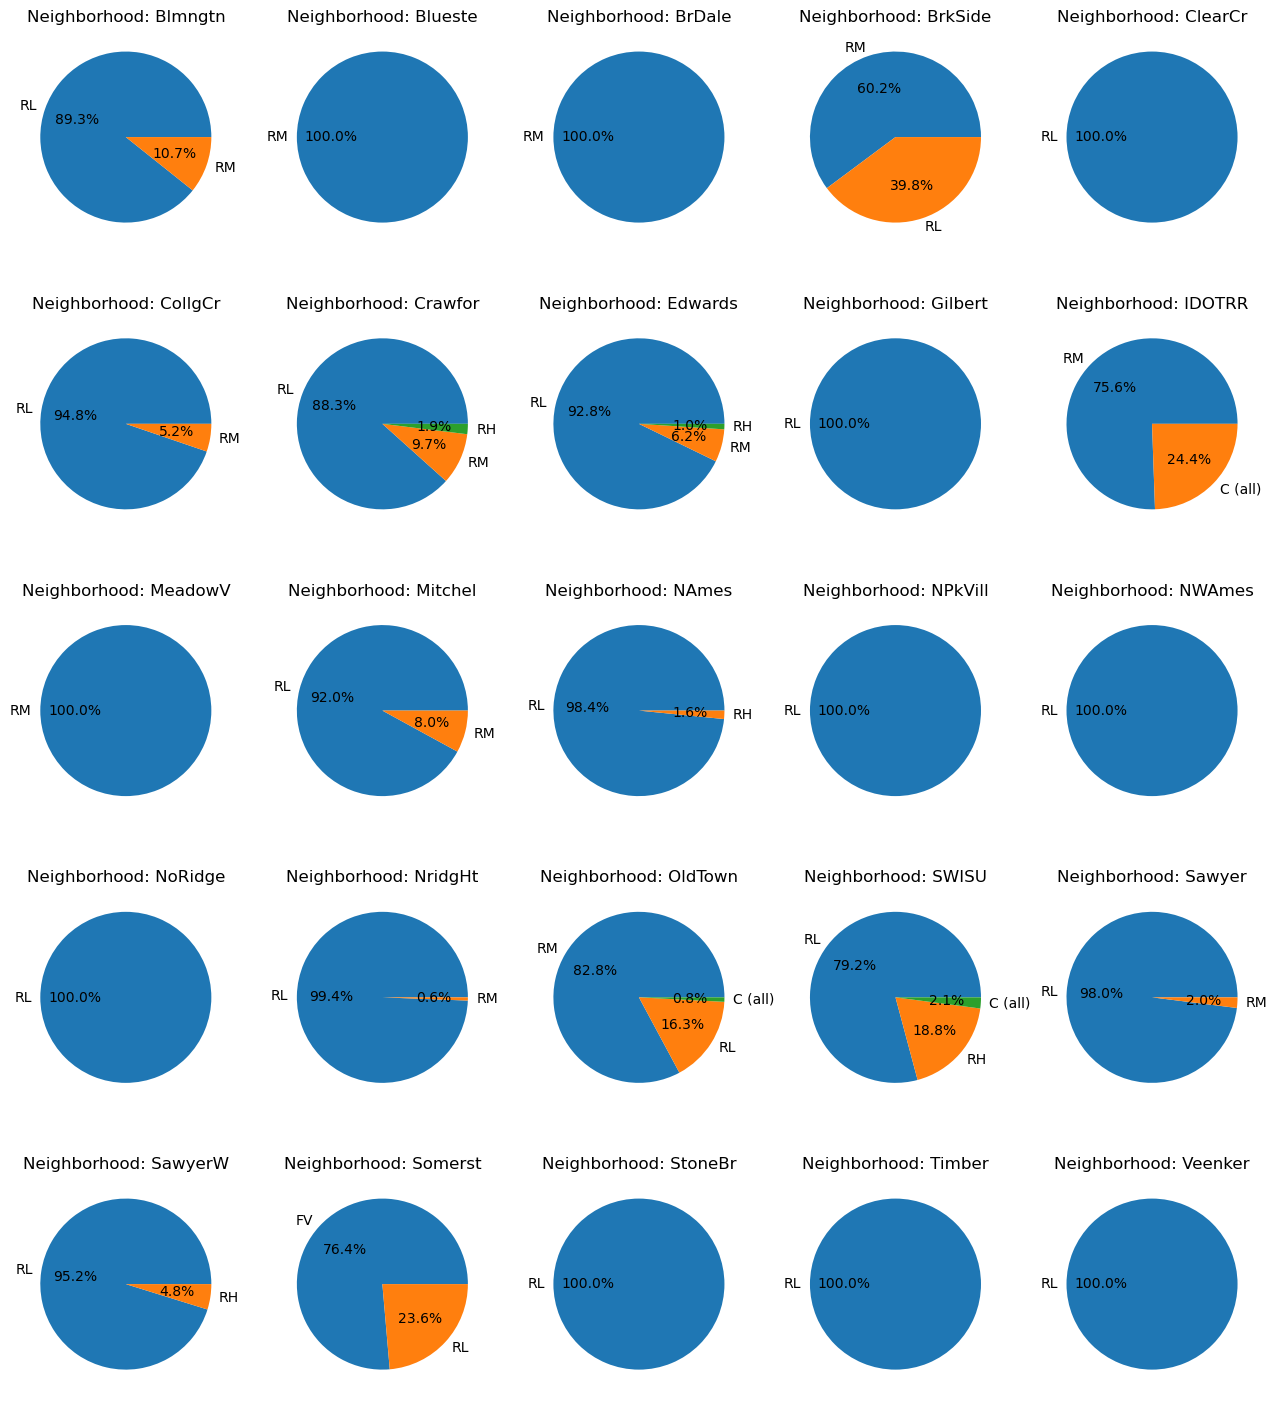

In [14]:
plt.figure(figsize=(16, 18))
plt.subplot(5, 5, 25)

for i, kind in enumerate(Neighborhood_vals):
    
    plt.subplot(5, 5, i + 1)
    
    vals = df1[df1.Neighborhood == kind]["MSZoning"].value_counts()
    plt.pie(x=vals, labels=vals.index, autopct='%1.1f%%')
    plt.title(f"Neighborhood: {kind}")

plt.show()

In [15]:
MSZoning_null_rows = df1[df1["MSZoning"].isna()].index

for row in MSZoning_null_rows:
    
    N_row = df1.iloc[row].Neighborhood
    MSZ_row = df1[df1["Neighborhood"] == N_row]["MSZoning"].value_counts().index[0]
    df1.at[row, "MSZoning"] = MSZ_row
    print("Neighborhood ", N_row, " --> ", MSZ_row, " MSZoning")

Neighborhood  IDOTRR  -->  RM  MSZoning
Neighborhood  IDOTRR  -->  RM  MSZoning
Neighborhood  IDOTRR  -->  RM  MSZoning
Neighborhood  Mitchel  -->  RL  MSZoning


In [16]:
# filling null values of a column with its 'mode'
for col in [
    "Utilities", "Exterior1st", "Exterior2nd",
    "MasVnrType", "Electrical", "KitchenQual", "Functional",
    "SaleType"
            ]:
    df1[col] = df1[col].fillna(df1[col].mode()[0])
    
# filling null values with a constant value, such as "--",
# because a null value is a valid value in these columns
for col in [
    "Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual",
    "GarageCond", "PoolQC", "Fence", "MiscFeature"
            ]:
    
    df1[col] = df1[col].fillna("--")

### 2. Filling Numerical null values

In [17]:
df1.loc[:, na_num_cols].isna().sum()

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [18]:
# filling null values of an instance based on similar instances using KNeighborsRegressor
for col in [
        "LotFrontage", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
        "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"
            ]:
    
    knn = KNeighborsRegressor(n_neighbors=10)
    
    num_df = df1.select_dtypes(np.number)
    non_na_num_cols = num_df.loc[:, num_df.isna().sum() == 0].columns
    
    X_train = num_df.loc[num_df[col].isna() == False, non_na_num_cols]
    y_train = num_df.loc[num_df[col].isna() == False, col]
    
    X_test = num_df.loc[num_df[col].isna() == True, non_na_num_cols]
    
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df1.loc[num_df[col].isna() == True, col] = y_pred

In [19]:
# No null values if we exclude garage columns
# We need the 'GarageYrBlt' column for feature engineering
# The 'GarageCars' and 'GarageArea' columns will be dealt with in the 'Handling Anomalies' section 
df1.isna().sum()[df1.isna().sum() > 0]

GarageYrBlt    159
GarageCars       1
GarageArea       1
dtype: int64

# Handling Anomalies

Some columns are strongly connected to each other. For example, if the _'MasVnrArea' = 0_ then _'MasVnrType' = "none"_ and vice versa. This is also true for _'Basement'_ columns and _'Garage'_ columns.

### 1. MasVnr

In [20]:
df2 =df1.copy()

In [21]:
df2.loc[df2["MasVnrType"] == "None", "MasVnrArea"].value_counts()

0.0      1737
1.0         3
33.1        2
145.1       1
261.6       1
198.0       1
122.3       1
85.4        1
109.9       1
152.9       1
90.8        1
106.8       1
181.5       1
68.2        1
285.0       1
65.8        1
312.0       1
344.0       1
369.9       1
431.3       1
147.7       1
111.4       1
96.5        1
45.2        1
288.0       1
186.5       1
124.7       1
Name: MasVnrArea, dtype: int64

In [22]:
# They all should be '0'
df2.loc[df2["MasVnrType"] == "None", "MasVnrArea"] = 0

In [23]:
# They all should be "None"
df2.loc[df2["MasVnrArea"] == 0, "MasVnrType"].value_counts()

None       1766
BrkFace       2
Stone         1
Name: MasVnrType, dtype: int64

In [24]:
df2.loc[df2["MasVnrArea"] == 0, "MasVnrType"] = "None"

### 2. Basement

In [25]:
cat_bsmt_cols = [col for col in df2.columns if "Bsmt" in col and df2[col].dtype == "object"]
num_bsmt_cols = [col for col in df2.columns if "Bsmt" in col and df2[col].dtype == np.number]

cat_bsmt_cols, num_bsmt_cols

(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'],
 ['BsmtFinSF1',
  'BsmtFinSF2',
  'BsmtUnfSF',
  'TotalBsmtSF',
  'BsmtFullBath',
  'BsmtHalfBath'])

In [26]:
# the value '--' means that the house has no basement
# thus, every numerical column should have value 0
# for a house that has no basement, and every categorical column
# should have value "--" for that house
df2[df2["BsmtQual"] == "--"][num_bsmt_cols].sum()

BsmtFinSF1       173.5
BsmtFinSF2        40.9
BsmtUnfSF       1201.6
TotalBsmtSF     1313.7
BsmtFullBath       0.9
BsmtHalfBath       0.0
dtype: float64

In [27]:
for col in cat_bsmt_cols:
    df2.loc[df2[col] == "--", cat_bsmt_cols] = "--"

In [28]:
df2.loc[df2["BsmtQual"] == "--", num_bsmt_cols] = 0

### 3. Garage

In [29]:
cat_grg_cols = [col for col in df2.columns if "Garage" in col and df2[col].dtype == "object"]
num_grg_cols = [col for col in df2.columns if "Garage" in col and df2[col].dtype == np.number and "Yr" not in col]

cat_grg_cols, num_grg_cols

(['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'],
 ['GarageCars', 'GarageArea'])

In [30]:
for col in cat_grg_cols:
    df2.loc[df2[col] == "--" , cat_grg_cols] = "--"
    
for col in num_grg_cols:
    df2.loc[df2[col] == 0 , num_grg_cols] = 0

In [31]:
# if a house doesn't have a garage, then all categorical
# columns should have value '--' for that house, and all
# of its numerical columns should be 0
df2.loc[df2["GarageType"] == "--", num_grg_cols] = 0

In [32]:
df2.loc[df2["GarageArea"] == 0, cat_grg_cols] = "--"

# Feature Engineering

In [33]:
df3 = df2.copy()

### 1. Year

The plots below tell us that newer houses tend to have higher prices. Newly remodeled houses also tend to make a house more valuable.

In [34]:
year_cols = [col for col in df3.columns if "Year" in col or "Yr" in col]
year_cols

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

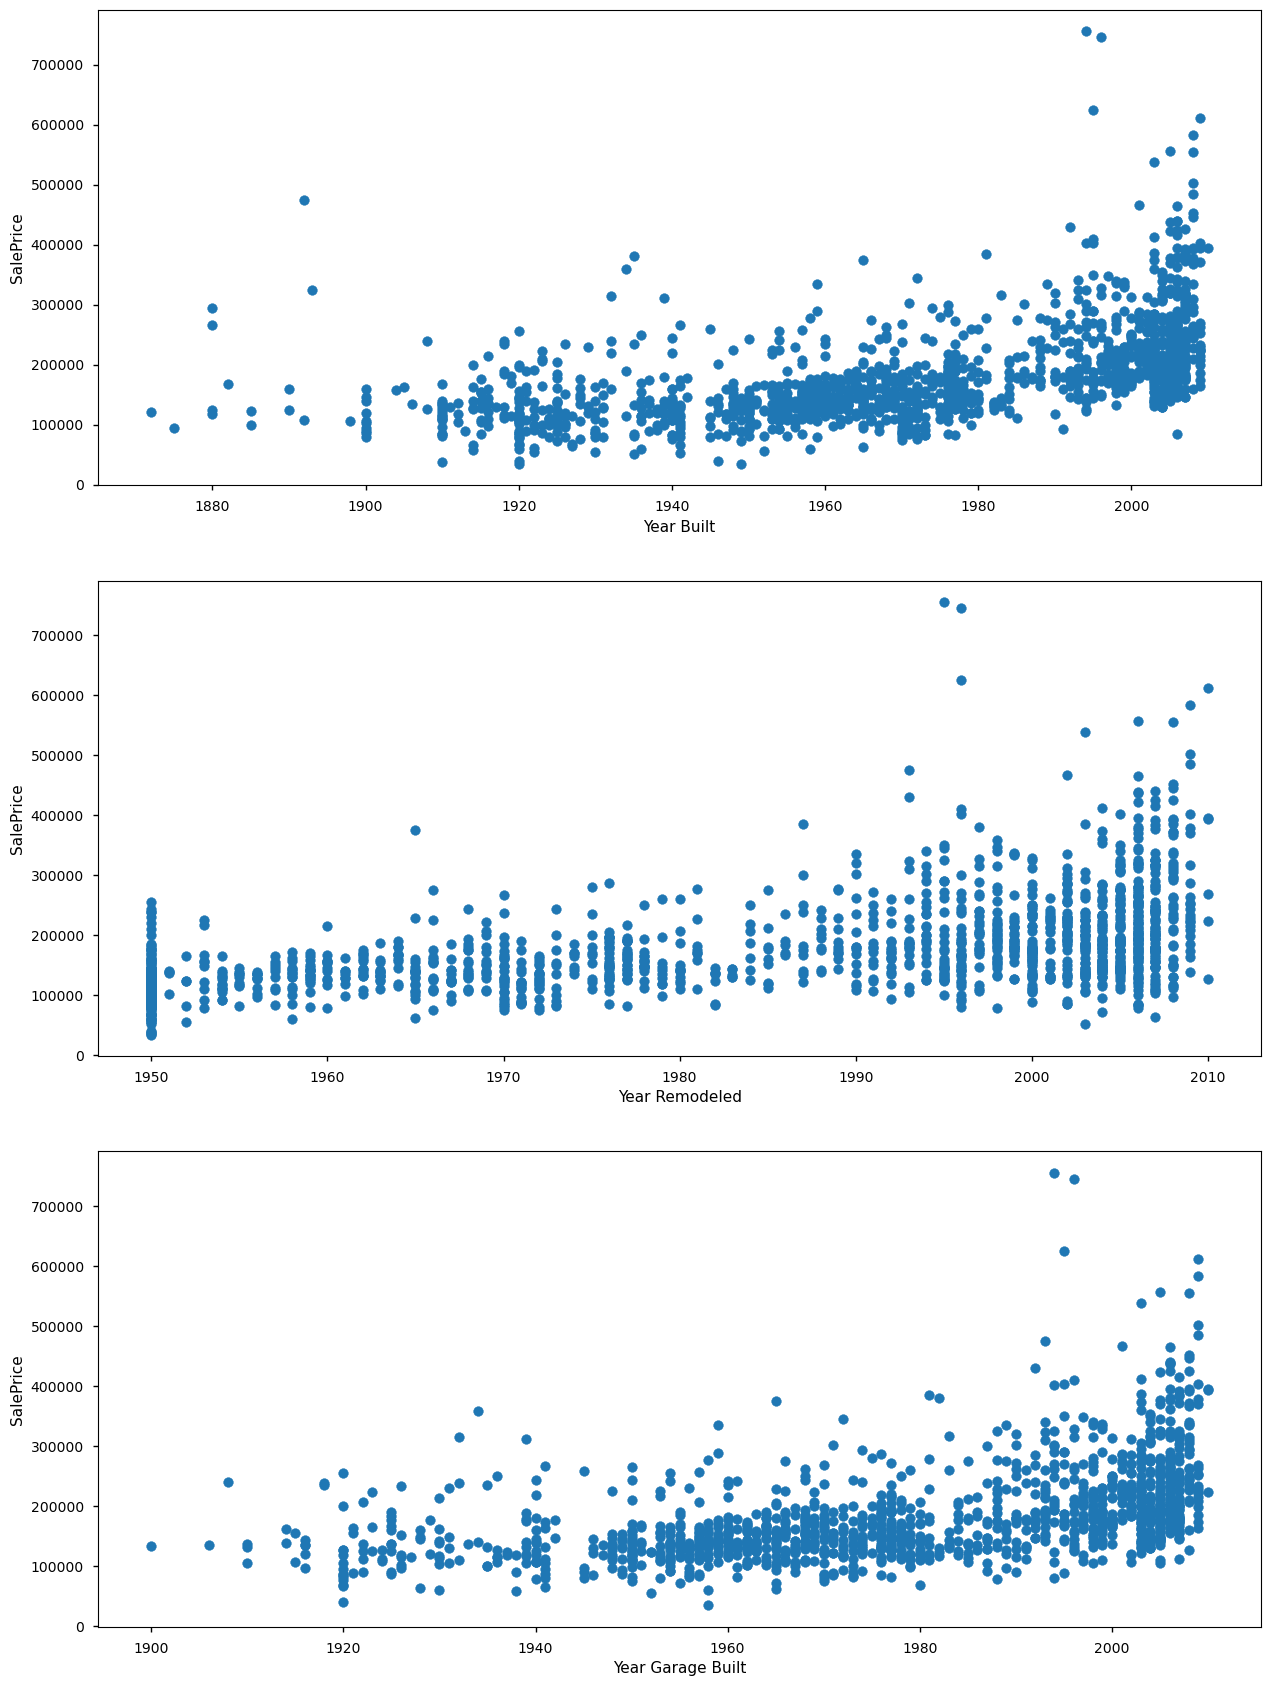

In [35]:
plt.figure(figsize=(15, 21))
plt.subplot(3, 1, 3)

plt.subplot(3, 1, 1)
plt.scatter(x=train_df["YearBuilt"], y=train_df["SalePrice"])
plt.xlabel("Year Built")
plt.ylabel("SalePrice")

plt.subplot(3, 1, 2)
plt.scatter(x=train_df["YearRemodAdd"], y=train_df["SalePrice"])
plt.xlabel("Year Remodeled")
plt.ylabel("SalePrice")

plt.subplot(3, 1, 3)
plt.scatter(x=train_df["GarageYrBlt"], y=train_df["SalePrice"])
plt.xlabel("Year Garage Built")
plt.ylabel("SalePrice")

plt.show()

In [36]:
garage_age = df3["YrSold"] - df3["GarageYrBlt"]
df3["garageAgeRank"] = np.max(garage_age) - garage_age + 1
df3["garageAgeRank"] = df3["garageAgeRank"].fillna(0)

house_age = df3["YrSold"] - df3["YearBuilt"]
df3["houseAgeRank"] = np.max(house_age) - house_age + 1

house_remod = df3["YrSold"] - df3["YearRemodAdd"]
df3["houseRemodRank"] = np.max(house_remod) - house_remod + 1

df3 = df3.drop(columns=year_cols)

### 2. New Features

The features below had negative effect on the final results. I'll Just comment them out.

In [37]:
# df3["SqFtPerRoom"] = df3["GrLivArea"] / (df3["TotRmsAbvGrd"] +
#                                         df3["FullBath"] +
#                                         df3["HalfBath"] +
#                                         df3["KitchenAbvGr"])

# df3["Total_Home_Quality"] = df3["OverallCond"] = df3["OverallQual"]

# df3["Total_Bathrooms"] = (df3["FullBath"] + 5.*df3["HalfBath"]
#                           + .5*df3["BsmtFullBath"]+ df3["BsmtHalfBath"])

# df3["HighQualSF"] = df3["1stFlrSF"] + df3["2ndFlrSF"]

# Feature Transformation

In [38]:
df4 = df3.copy()

In [39]:
num_cols = df4.select_dtypes(np.number).columns
len(num_cols)

33

In [40]:
skew_df = pd.DataFrame(df4.select_dtypes(np.number).columns, columns=["Feature"])
skew_df["Skew"] = skew_df["Feature"].apply(lambda feature: stats.skew(df4[feature]))
skew_df["Abs skew"] = skew_df["Skew"].apply(abs)
skew_df["Skewed"] = skew_df["Abs skew"].apply(lambda x: True if x > .5 else False)
skew_df

Feature       Skew   Abs skew  Skewed
0      LotFrontage   1.330465   1.330465    True
1          LotArea  12.822431  12.822431    True
2      OverallQual   0.197110   0.197110   False
3      OverallCond   0.570312   0.570312    True
4       MasVnrArea   2.624724   2.624724    True
5       BsmtFinSF1   1.431881   1.431881    True
6       BsmtFinSF2   4.164826   4.164826    True
7        BsmtUnfSF   0.919387   0.919387    True
8      TotalBsmtSF   1.093256   1.093256    True
9         1stFlrSF   1.469604   1.469604    True
10        2ndFlrSF   0.861675   0.861675    True
11    LowQualFinSF  12.088761  12.088761    True
12       GrLivArea   1.269358   1.269358    True
13    BsmtFullBath   0.627824   0.627824    True
14    BsmtHalfBath   3.946096   3.946096    True
15        FullBath   0.167606   0.167606   False
16        HalfBath   0.694566   0.694566    True
17    BedroomAbvGr   0.326324   0.326324   False
18    KitchenAbvGr   4.302254   4.302254    True
19    TotRmsAbvGrd   0.758367   0.758367    True
20      Fireplaces   0.733495   0.733495    True
21      GarageCars  -0.221649   0.221649   False
22      GarageArea   0.236857   0.236857   False
23      WoodDeckSF   1.842433   1.842433    True
24     OpenPorchSF   2.535114   2.535114    True
25   EnclosedPorch   4.003891   4.003891    True
26       3SsnPorch  11.376065  11.376065    True
27     ScreenPorch   3.946694   3.946694    True
28        PoolArea  16.898328  16.898328    True
29         MiscVal  21.947195  21.947195    True
30   garageAgeRank  -0.823444   0.823444    True
31    houseAgeRank  -0.598609   0.598609    True
32  houseRemodRank  -0.450226   0.450226   False

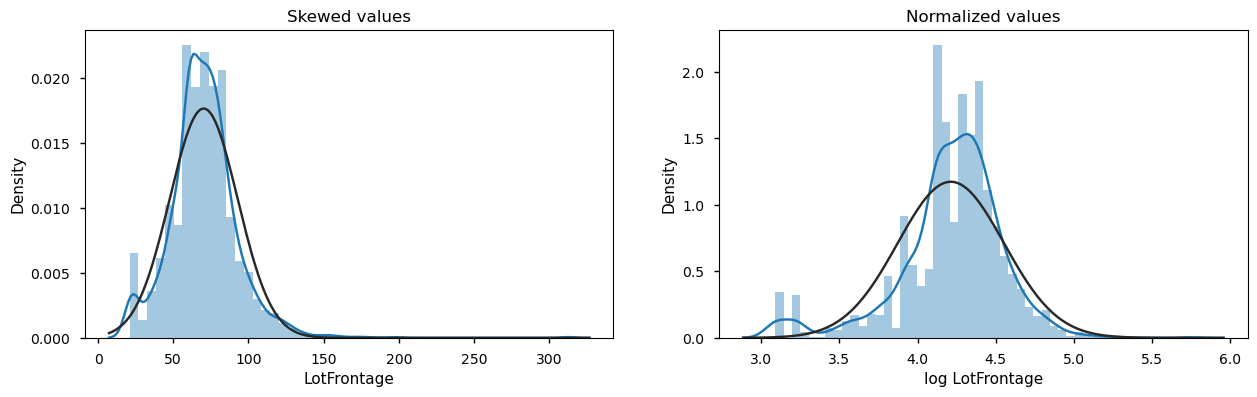

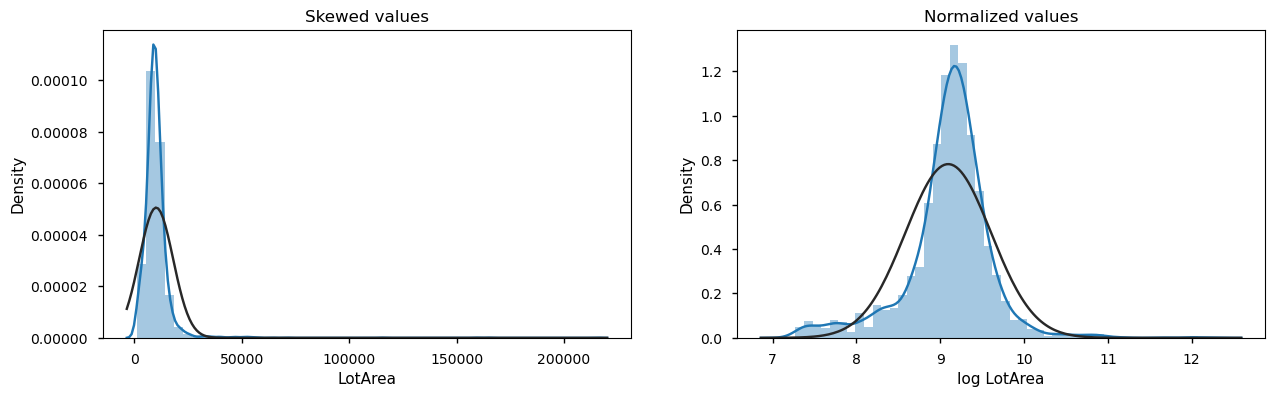

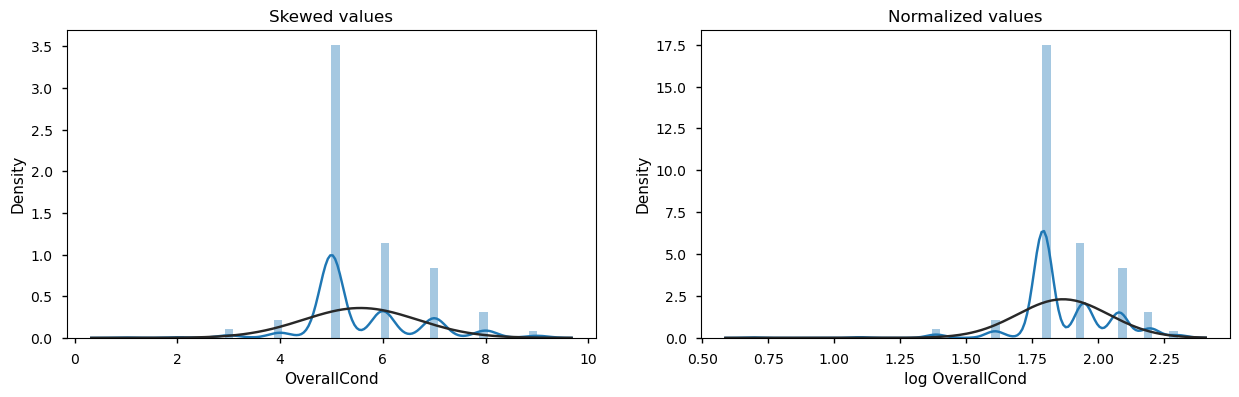

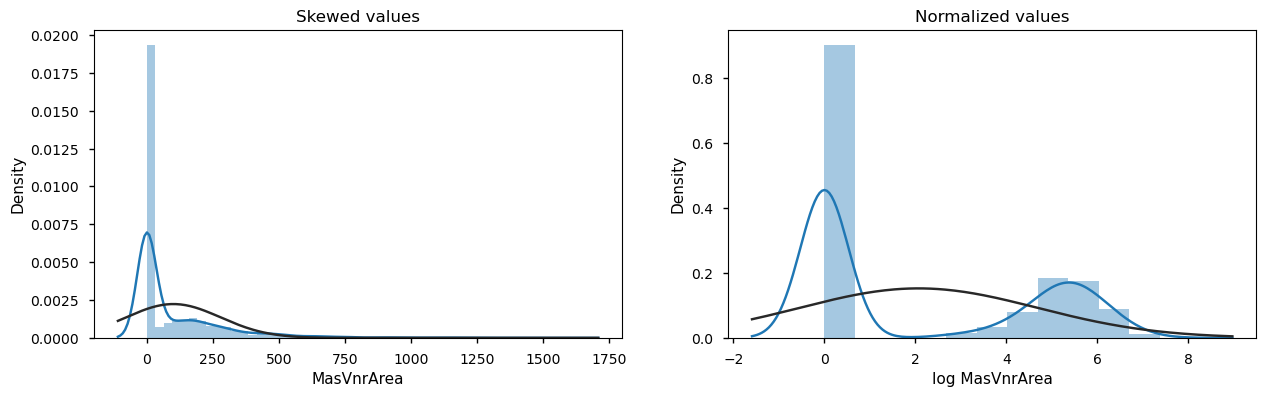

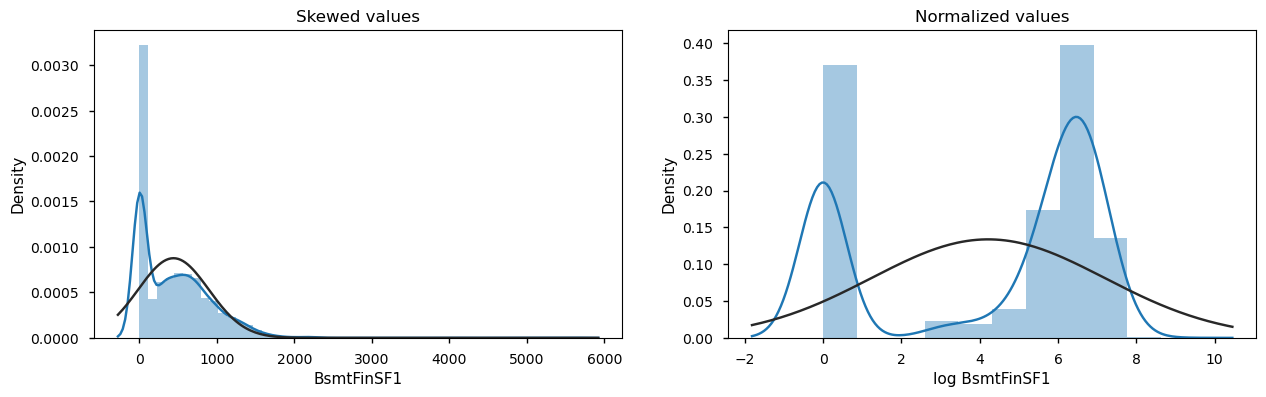

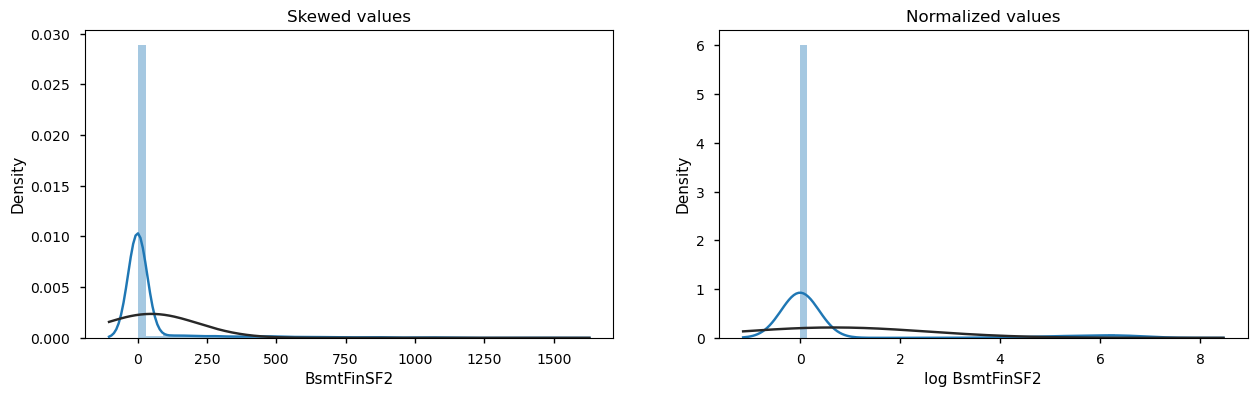

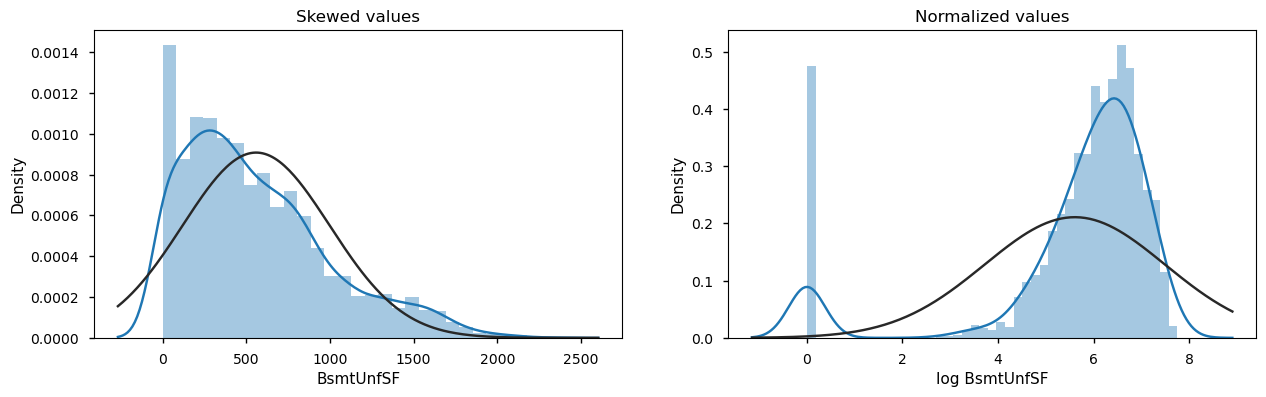

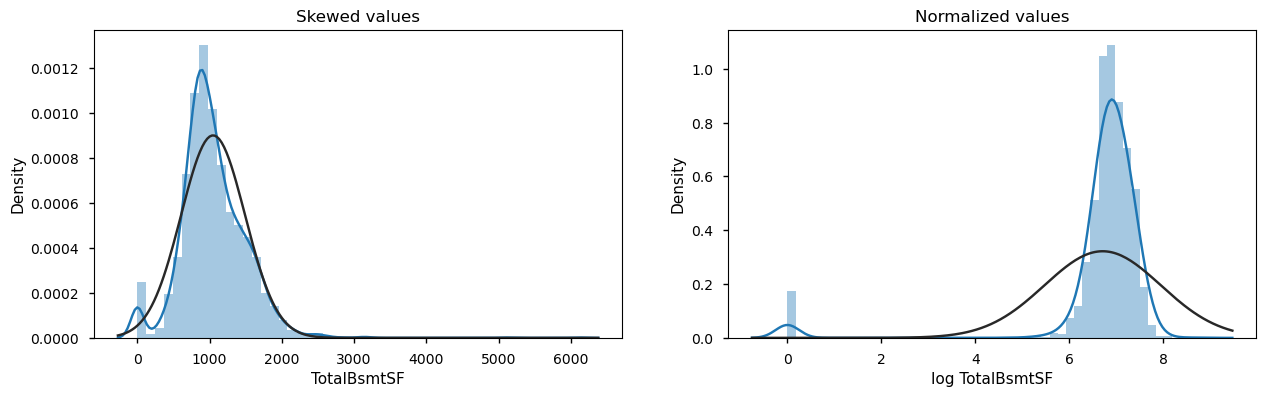

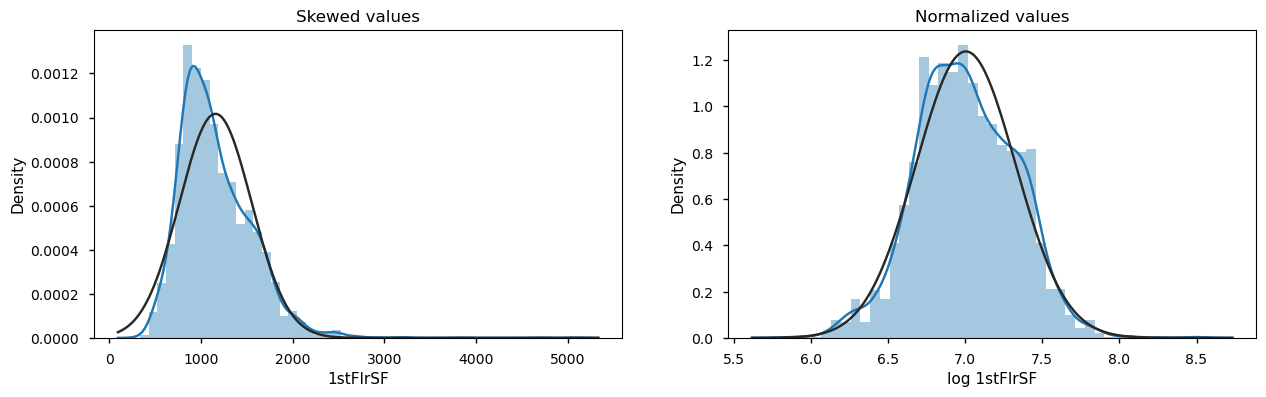

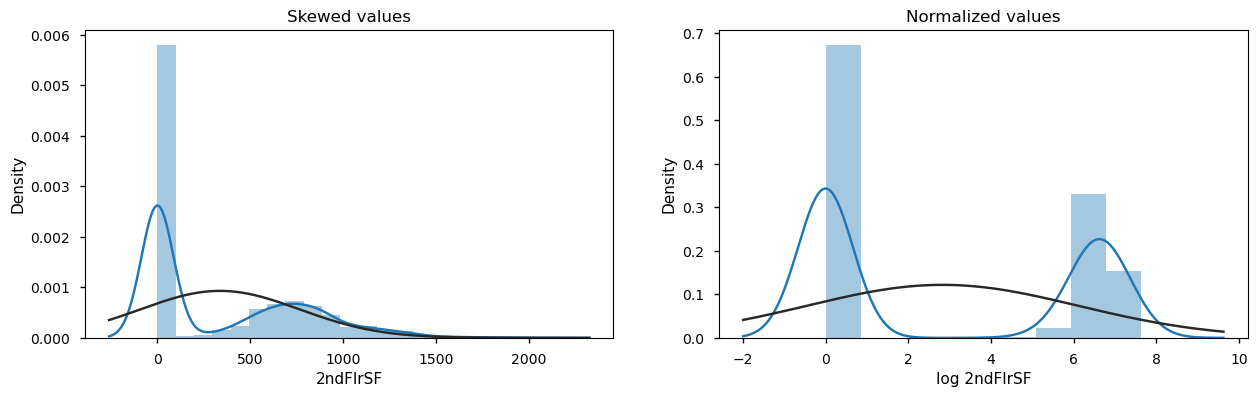

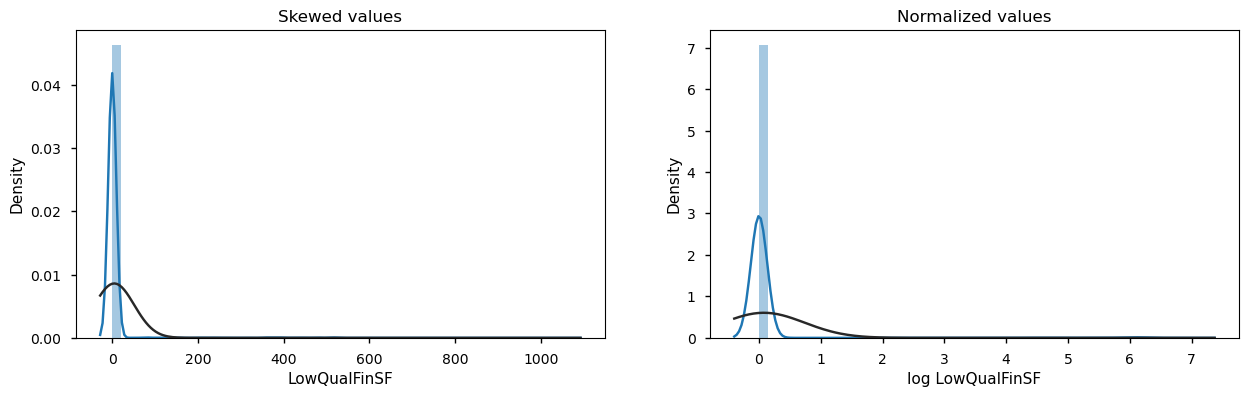

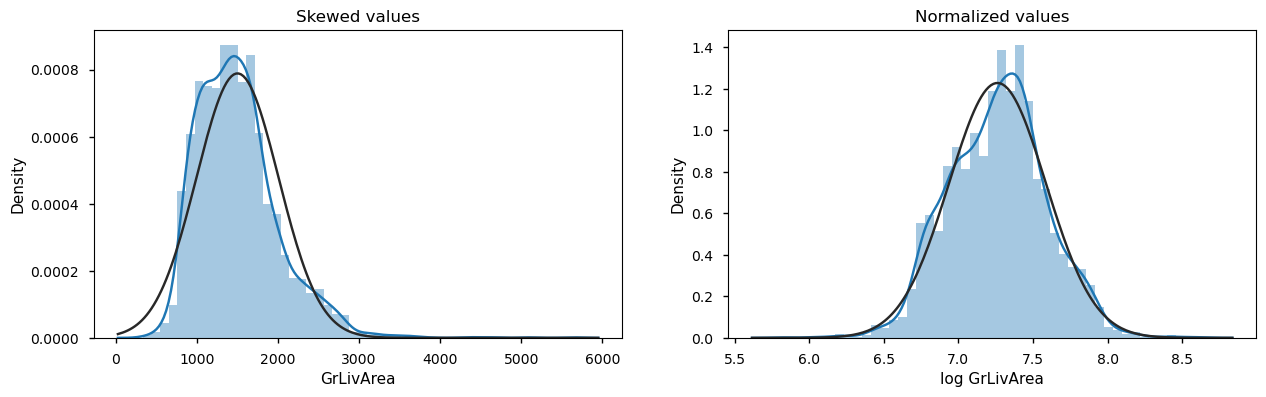

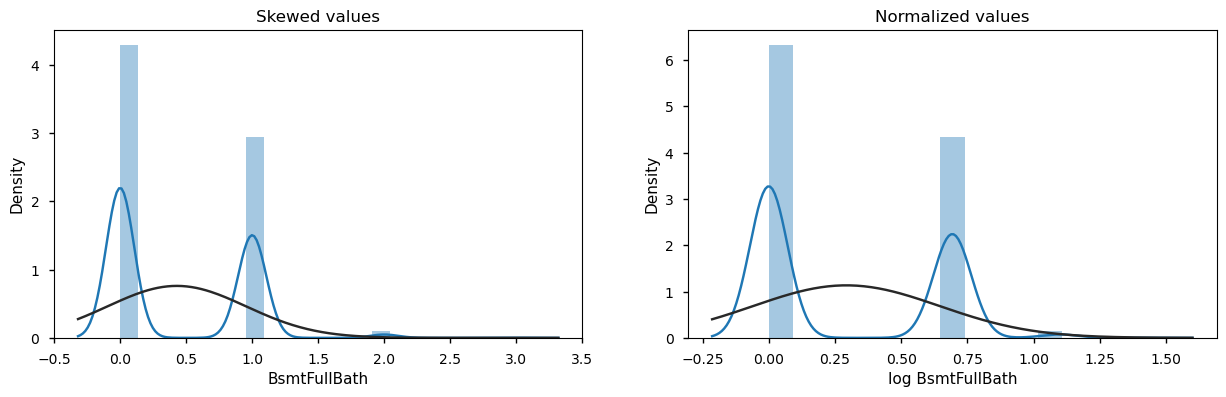

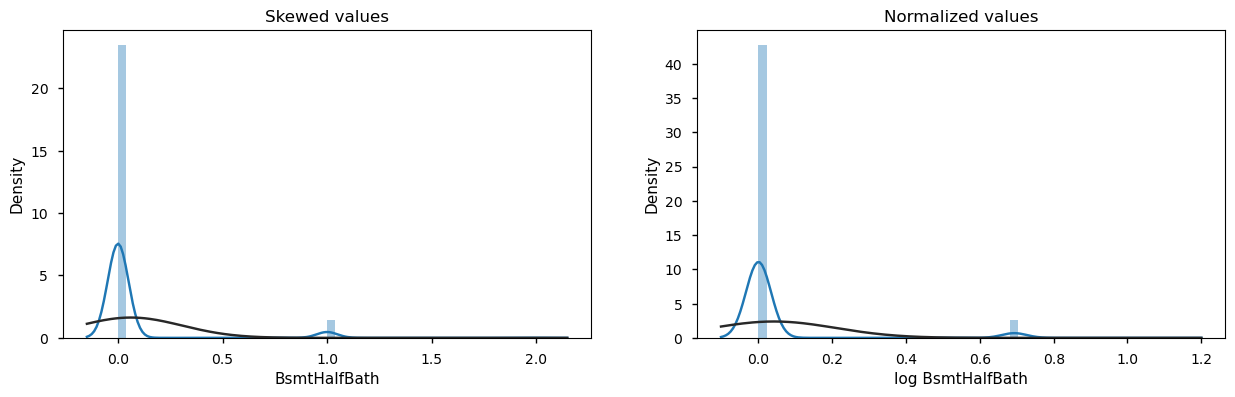

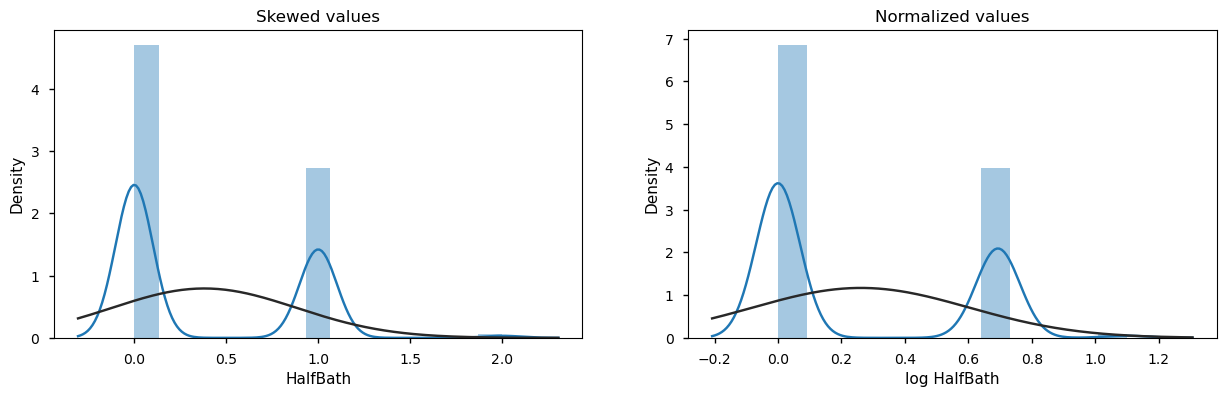

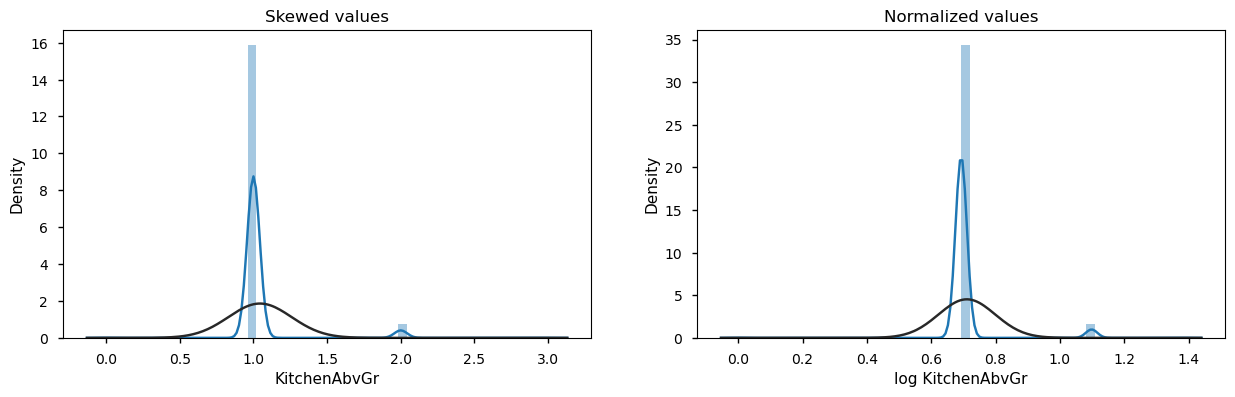

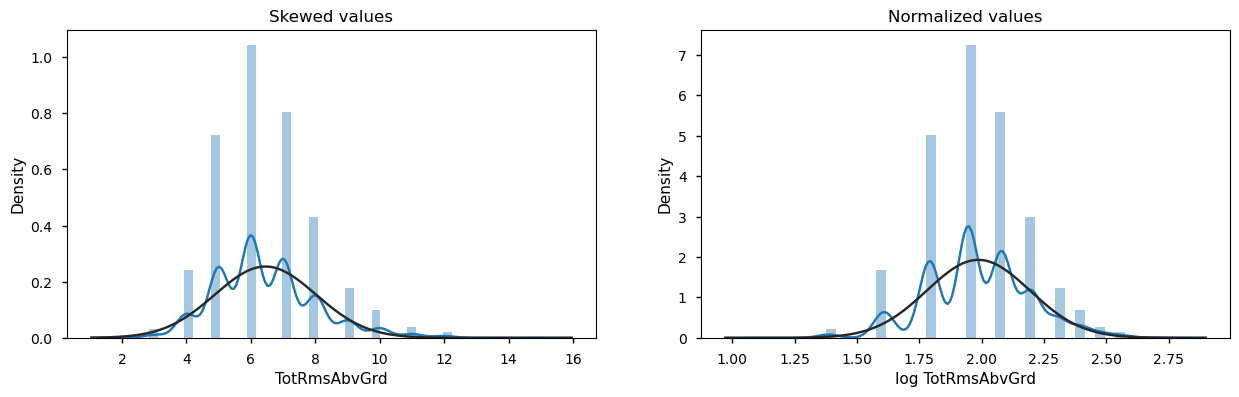

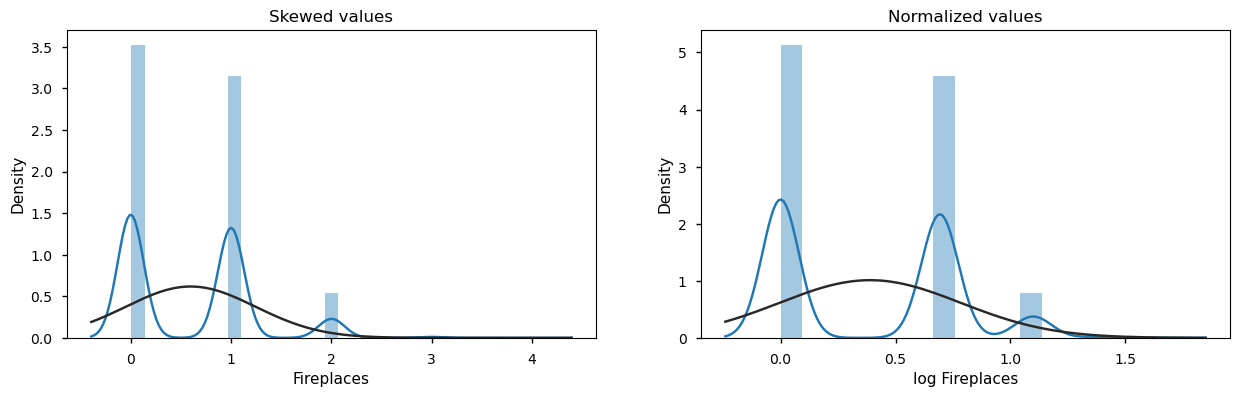

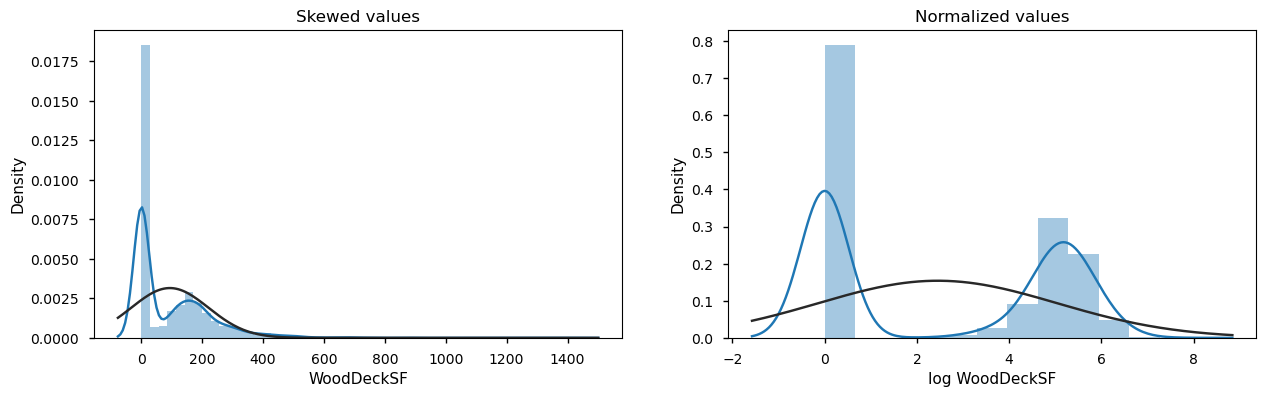

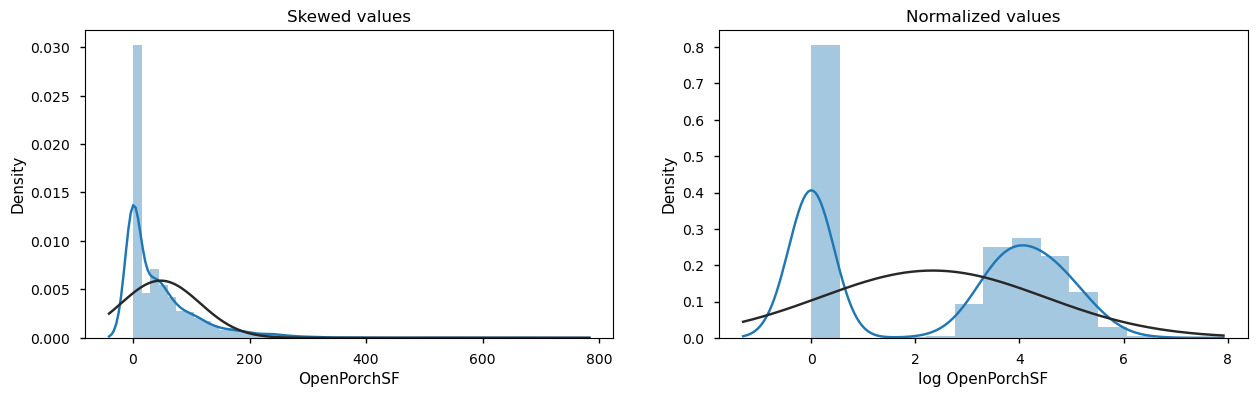

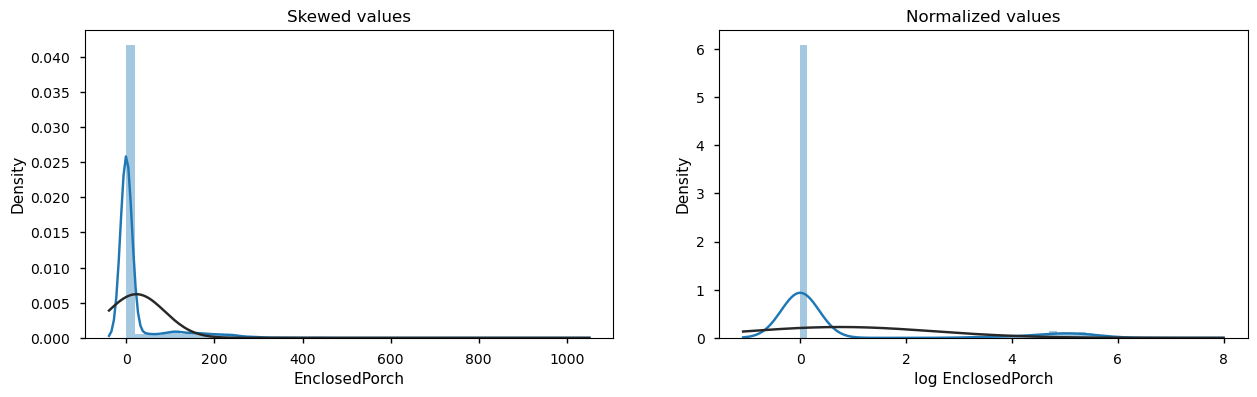

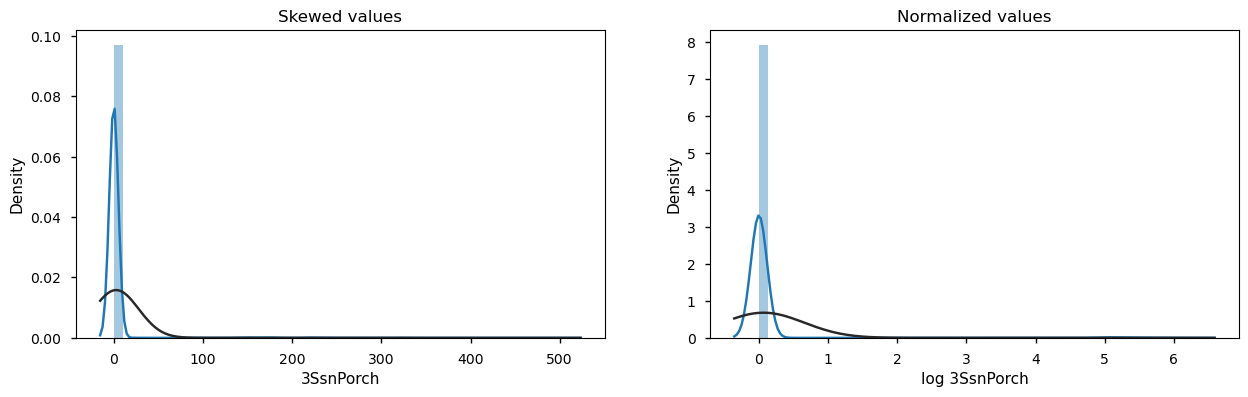

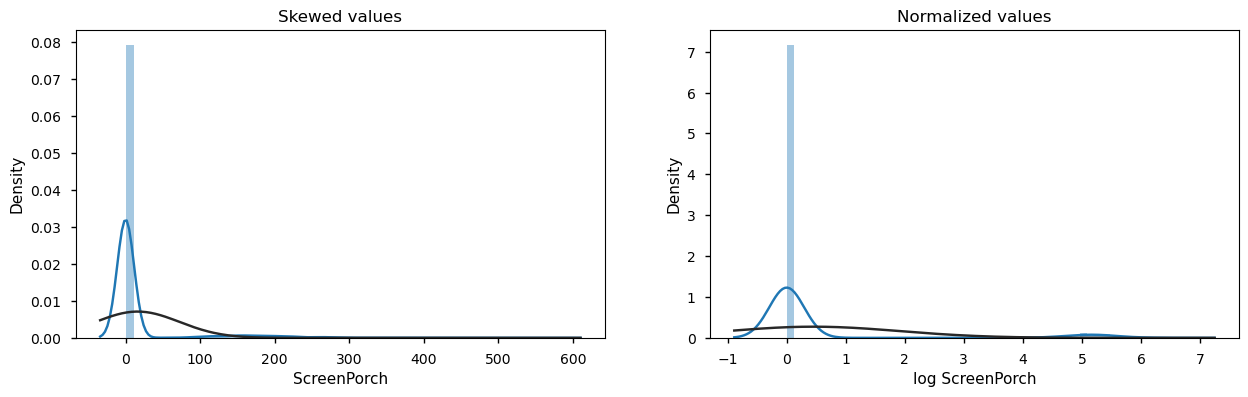

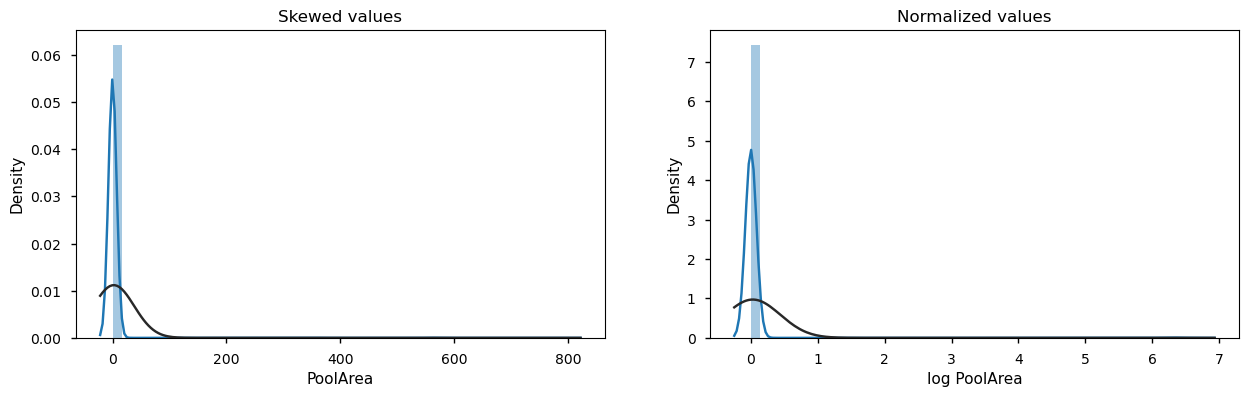

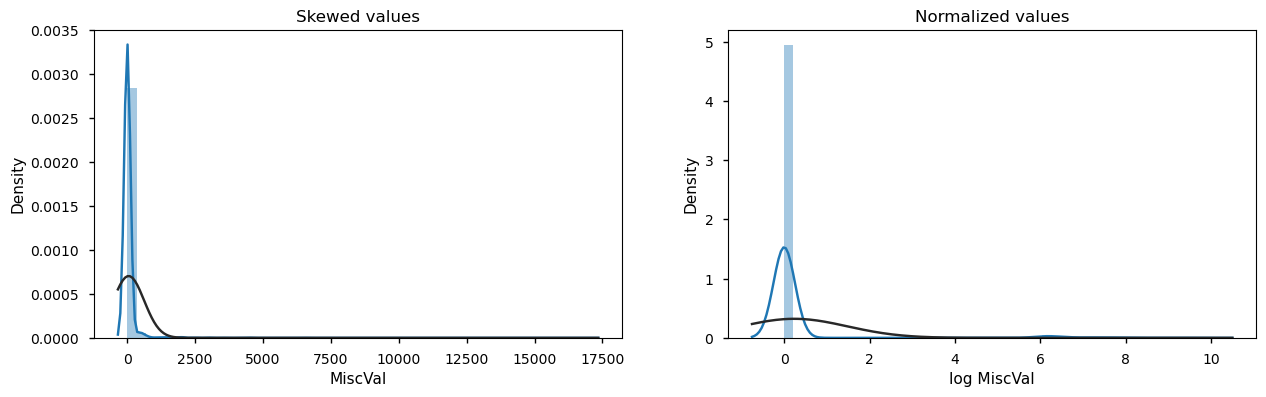

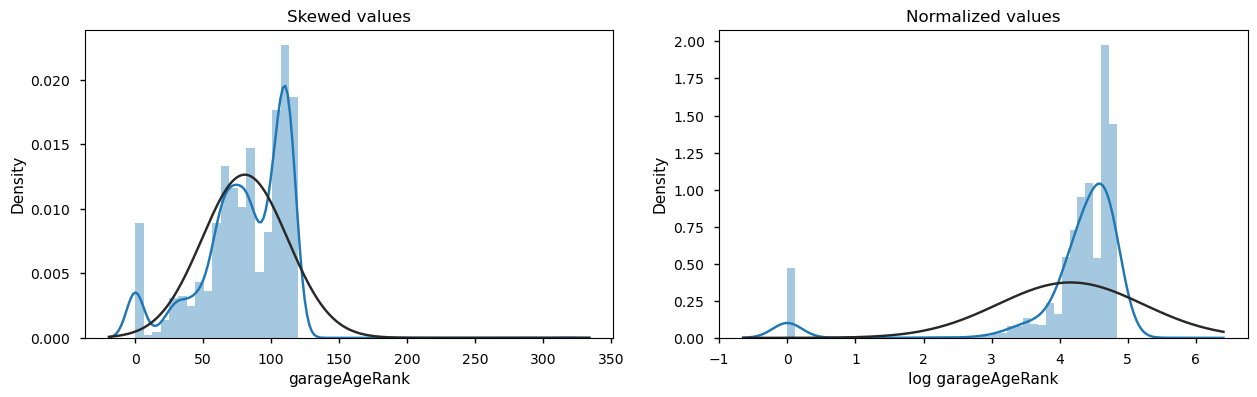

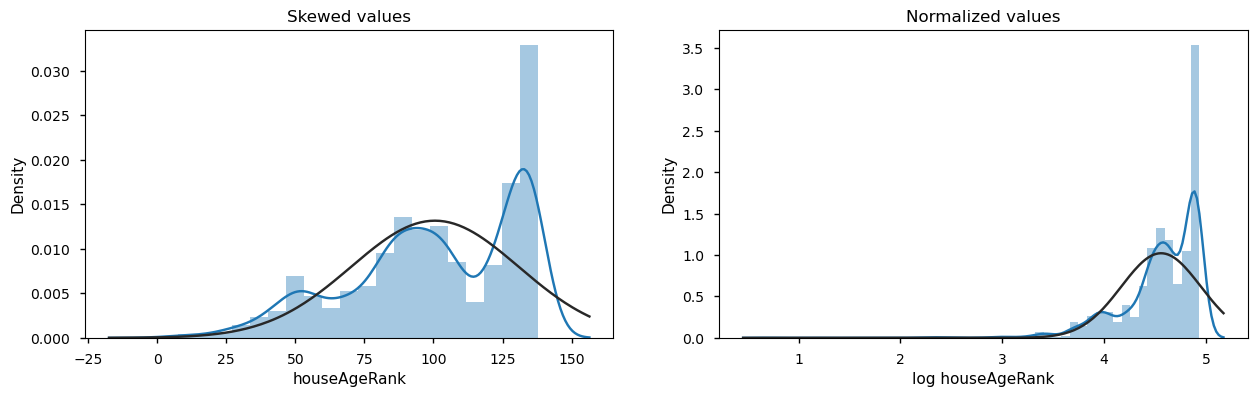

In [41]:

for col in skew_df.query("Skewed == True")["Feature"].values:
    
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 2)
    plt.subplot(1, 2, 1)
    sns.distplot(df4[col], kde=True, fit=stats.norm)
    plt.title("Skewed values")

    transformed_values = np.log1p(df4[col])
    plt.subplot(1, 2, 2)
    sns.distplot(transformed_values, kde=True, fit=stats.norm)
    plt.title("Normalized values")
    plt.xlabel(f"log {col}")

    plt.show()
    df4[col] = transformed_values

# Encoding Categorical Features

In [42]:
df5 = df4.copy()

In [43]:
cat_cols = df5.select_dtypes("object").columns

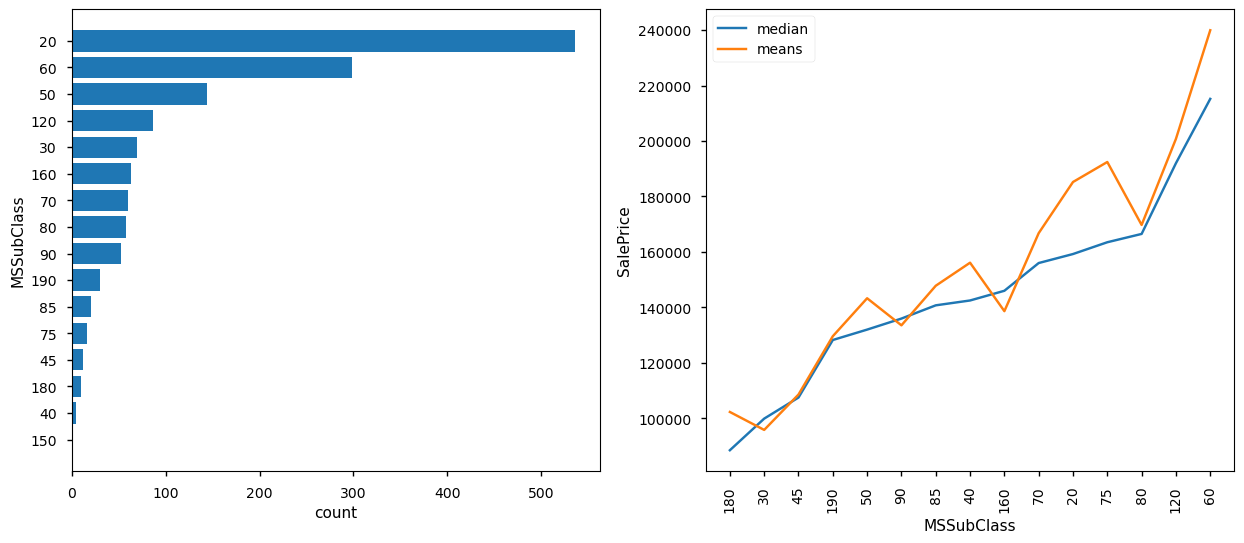

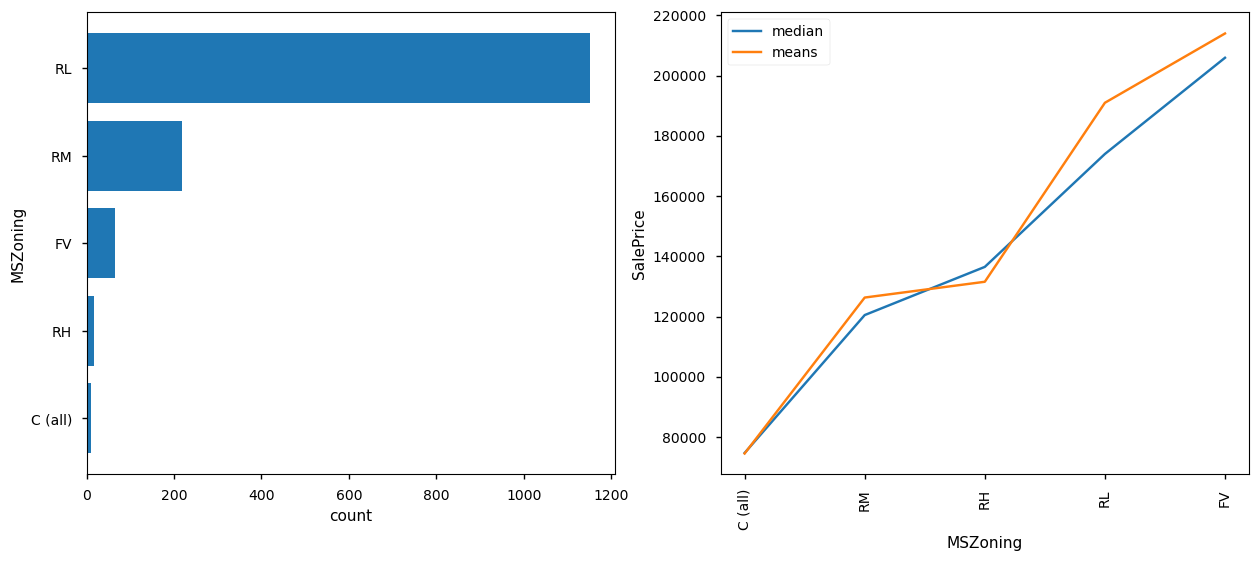

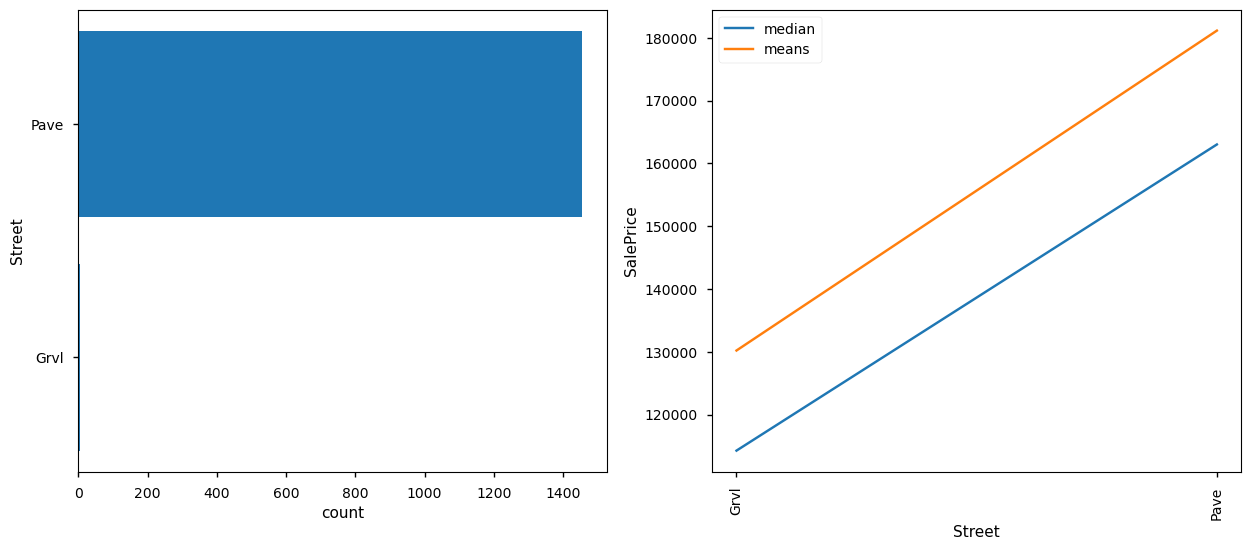

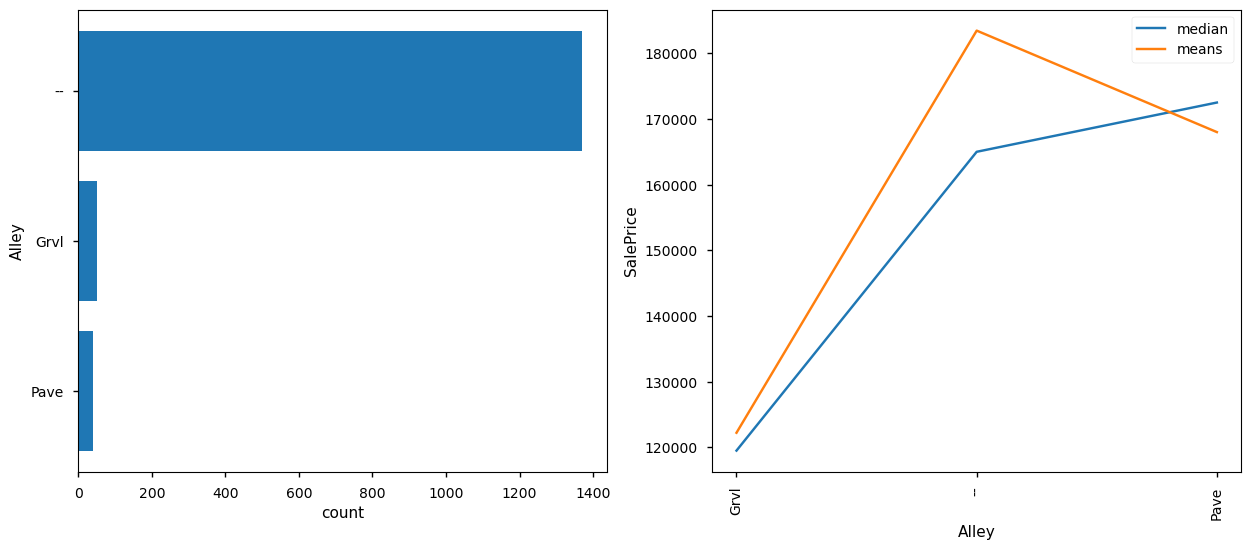

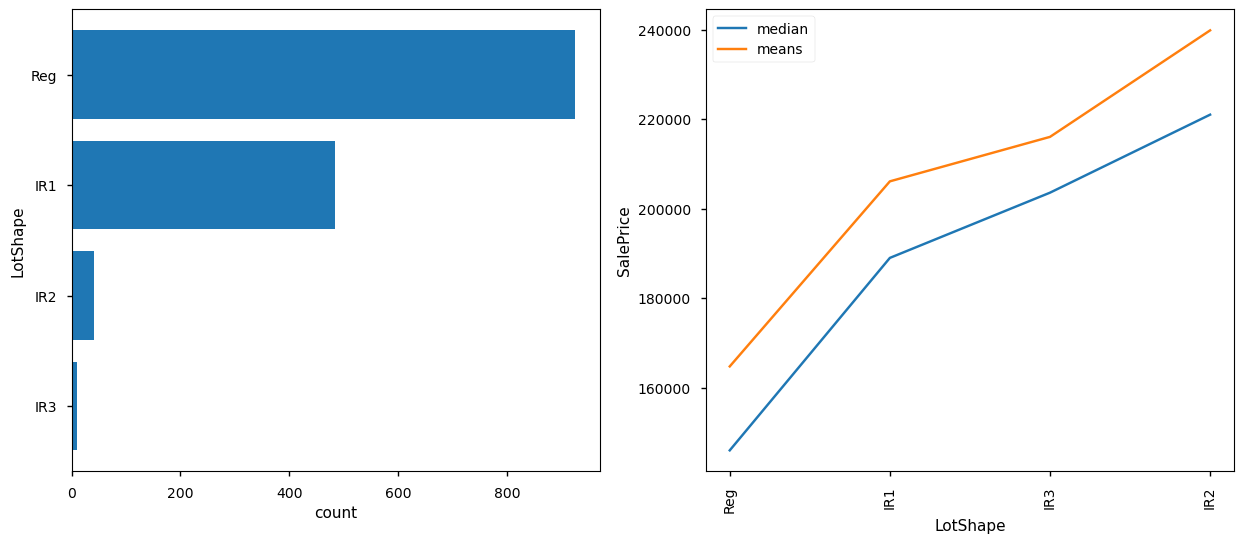

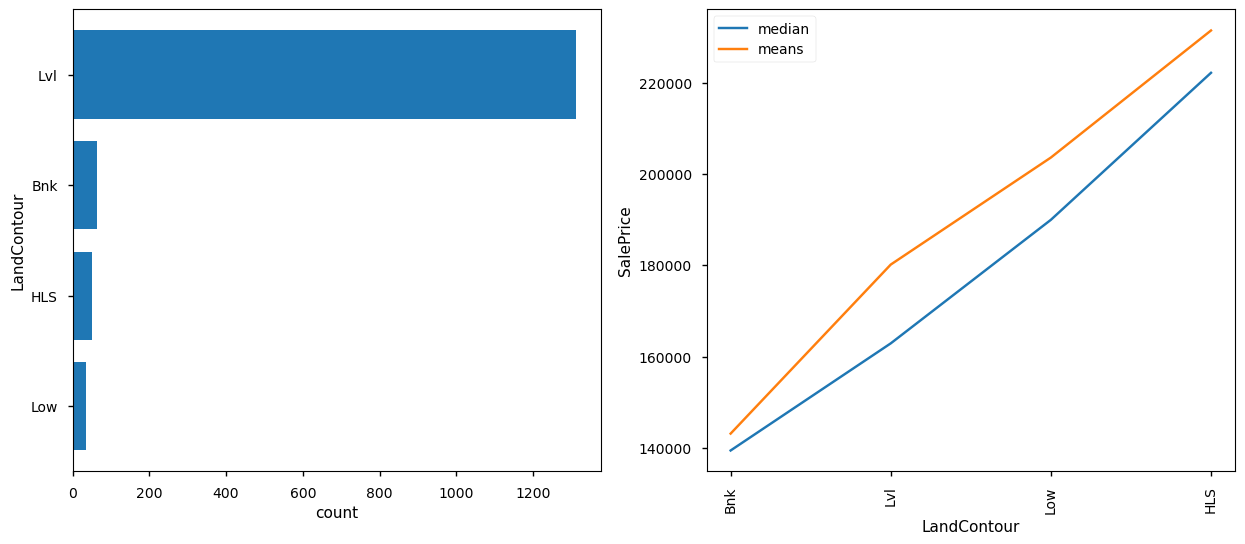

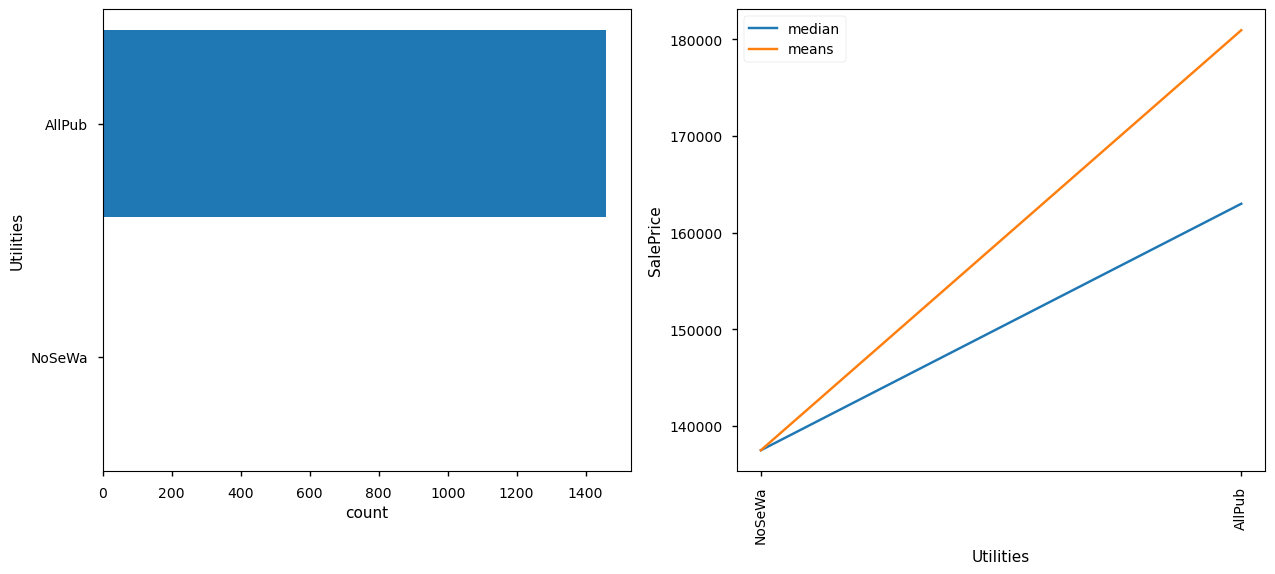

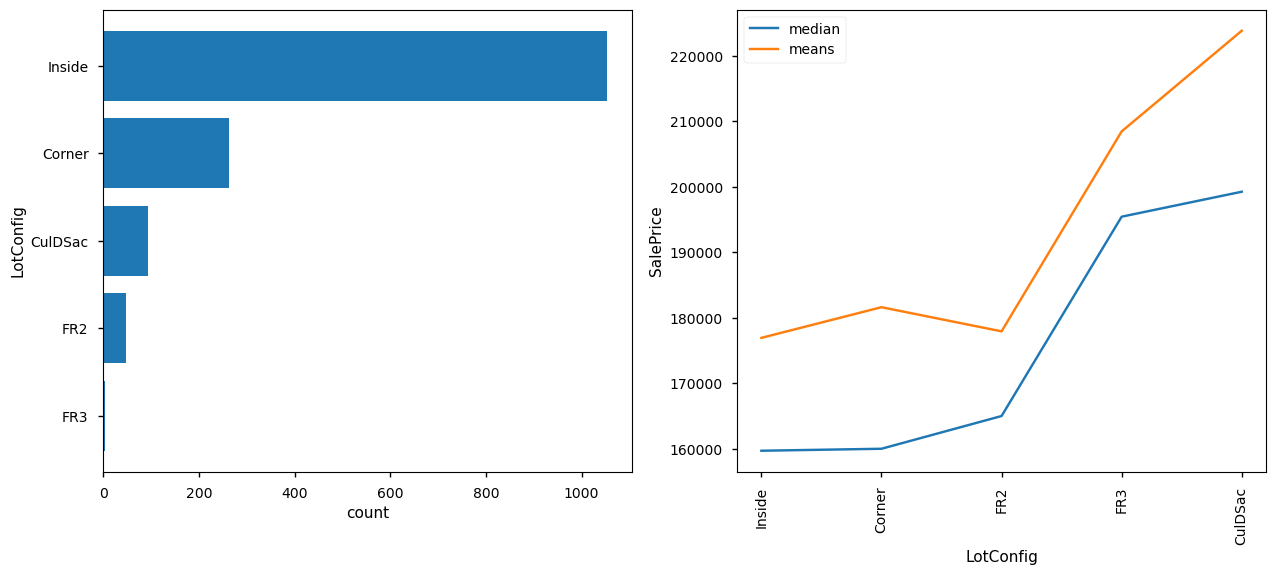

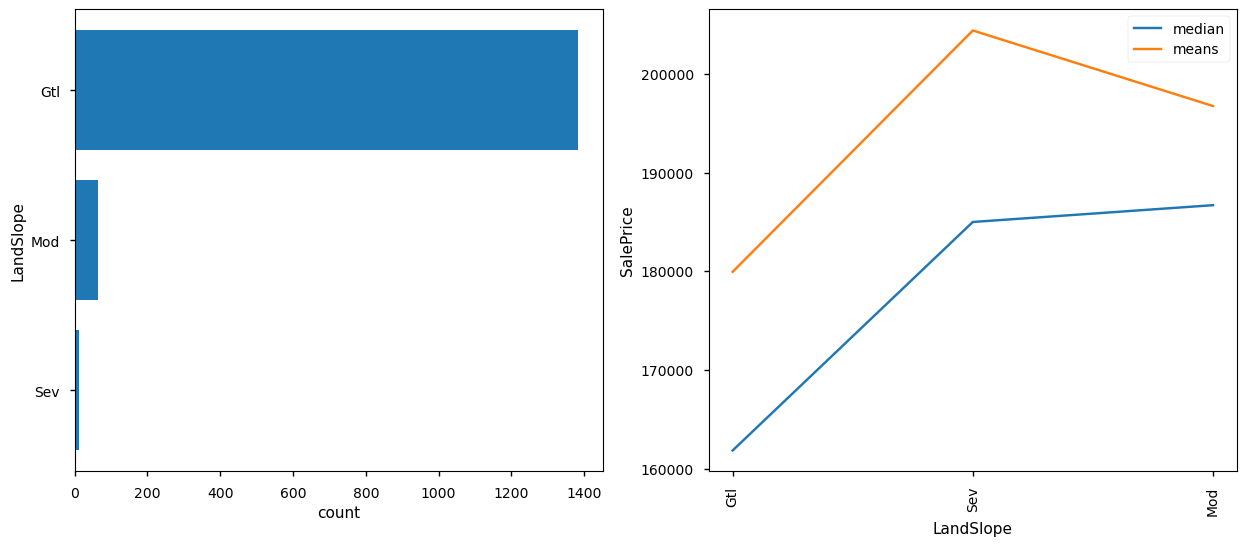

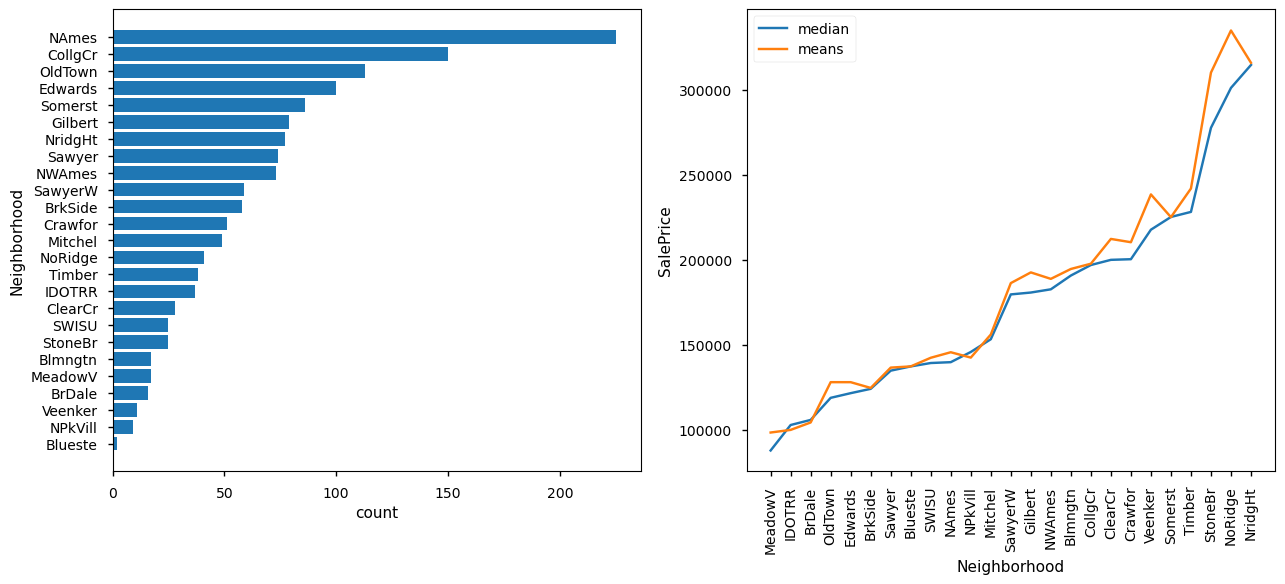

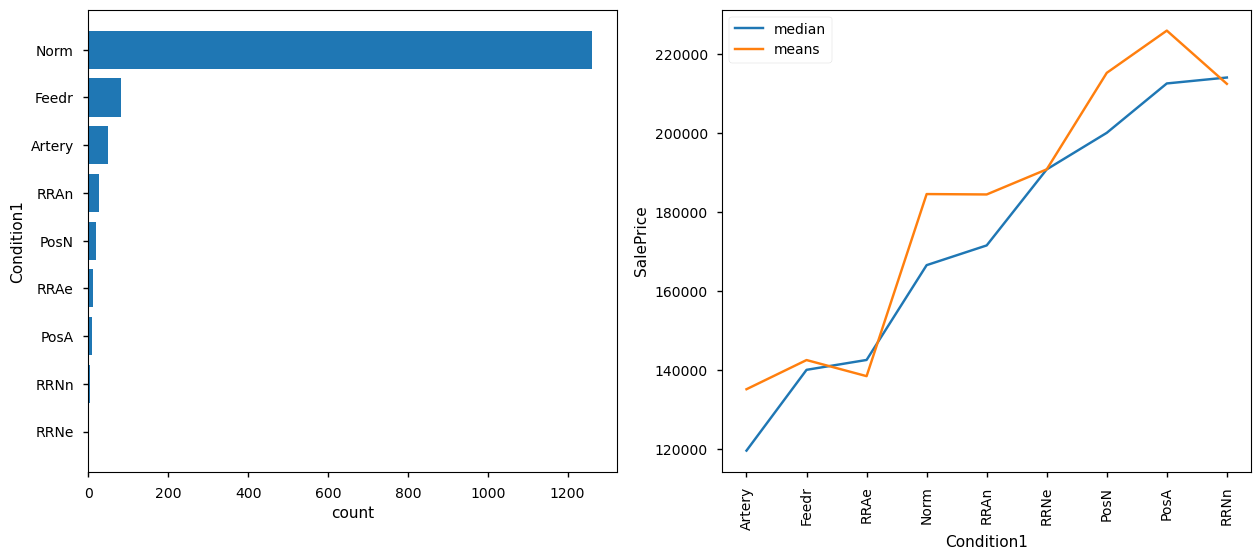

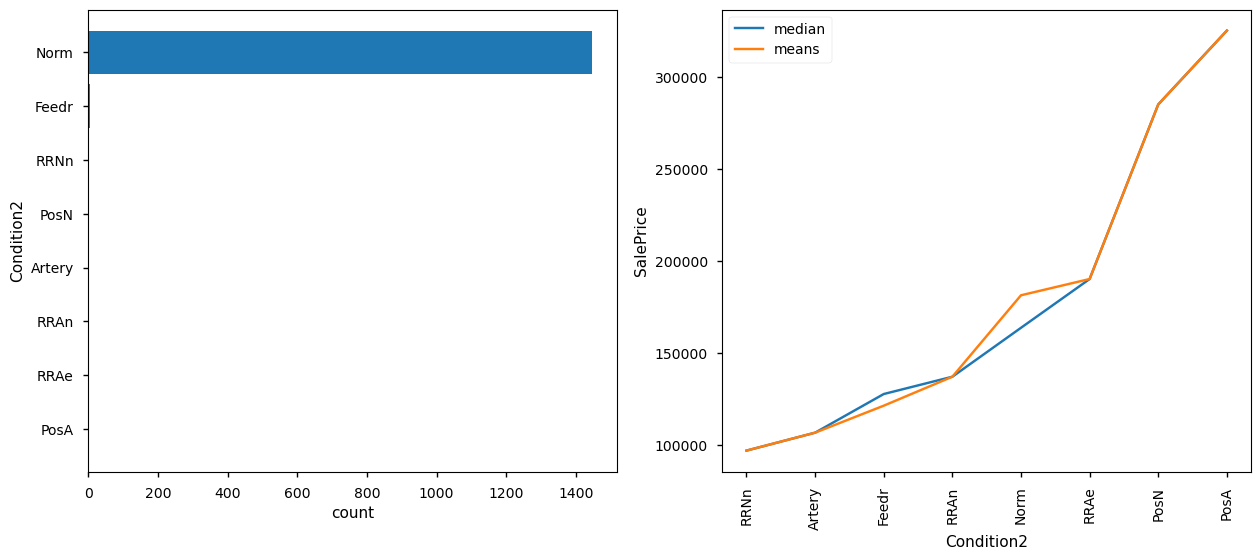

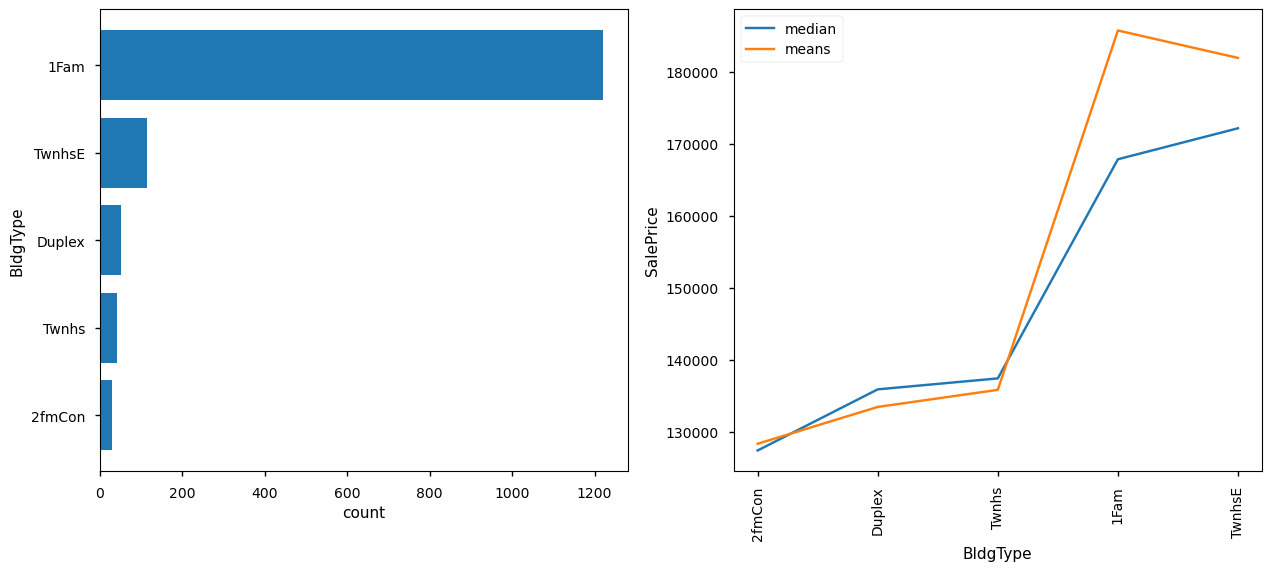

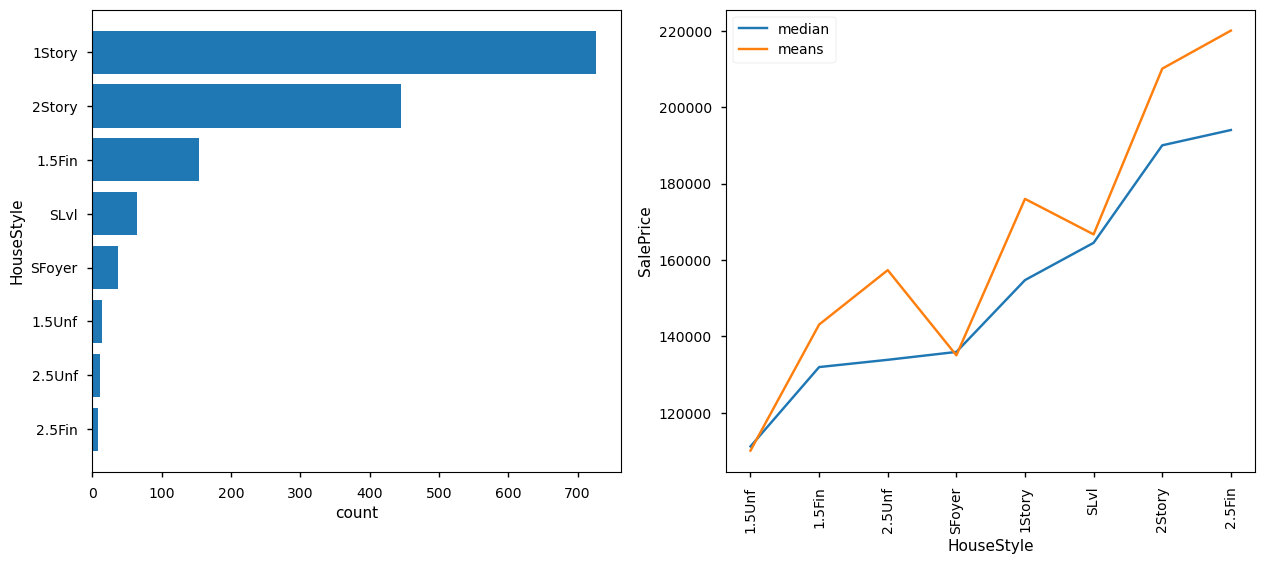

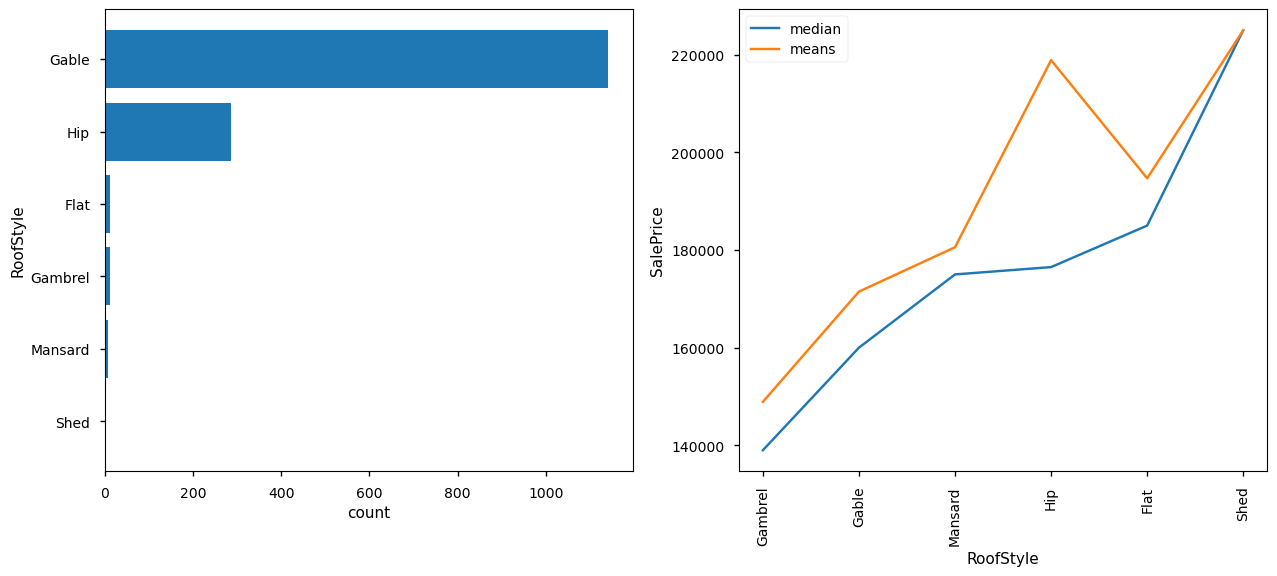

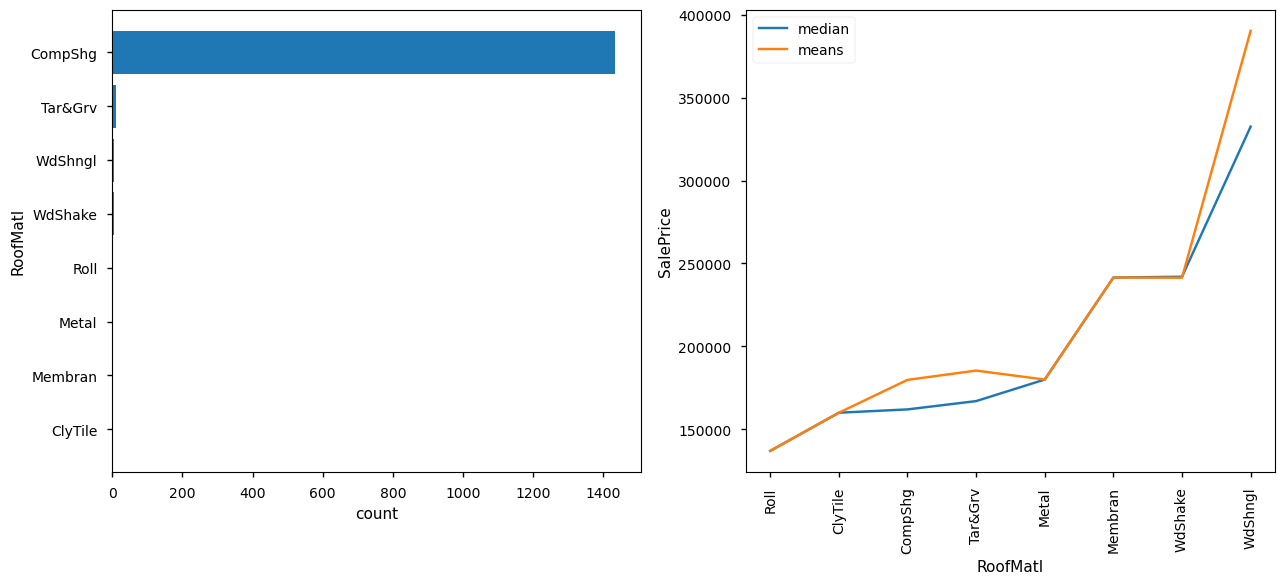

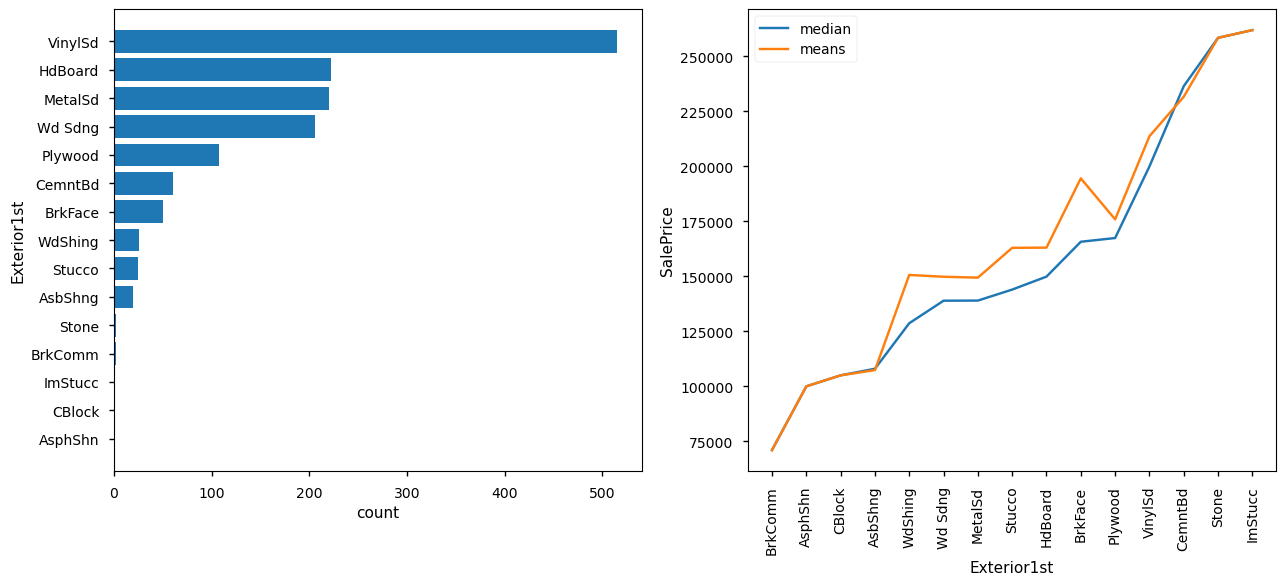

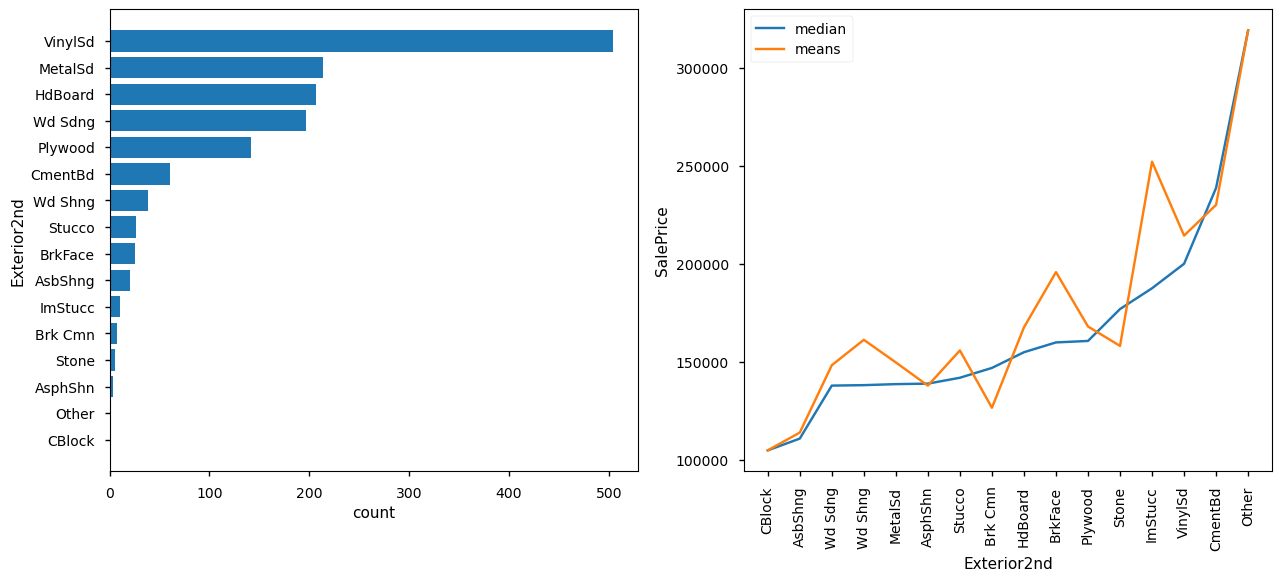

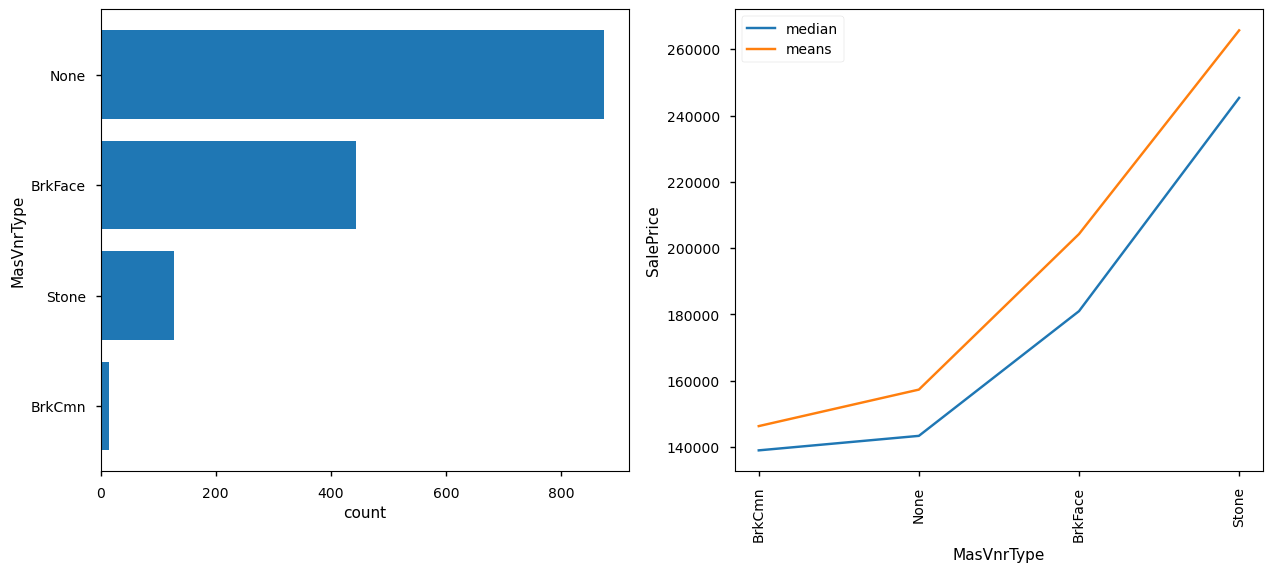

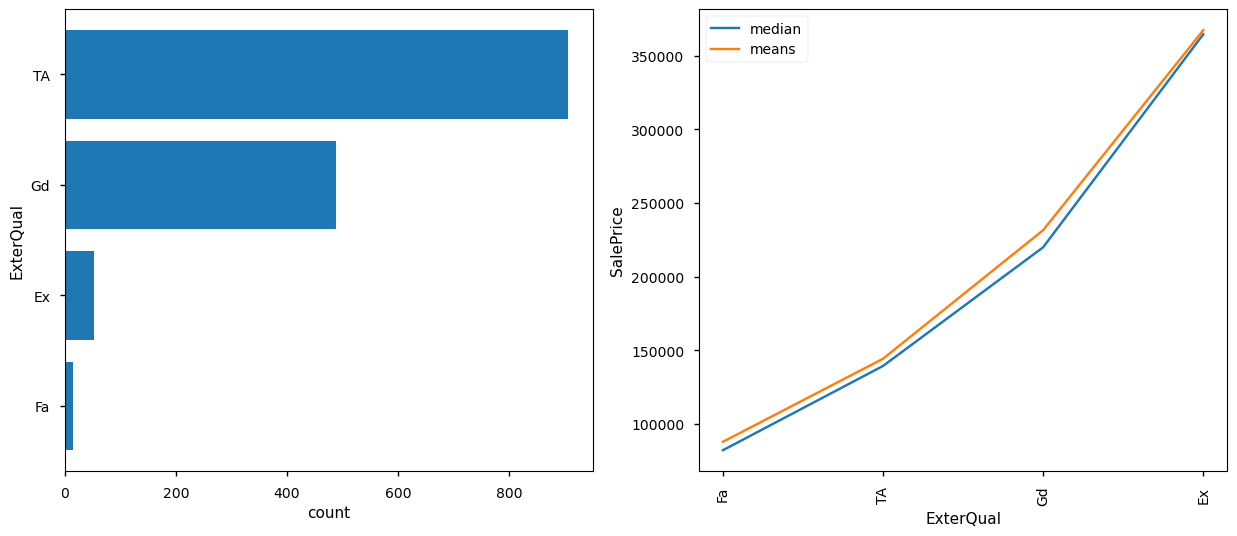

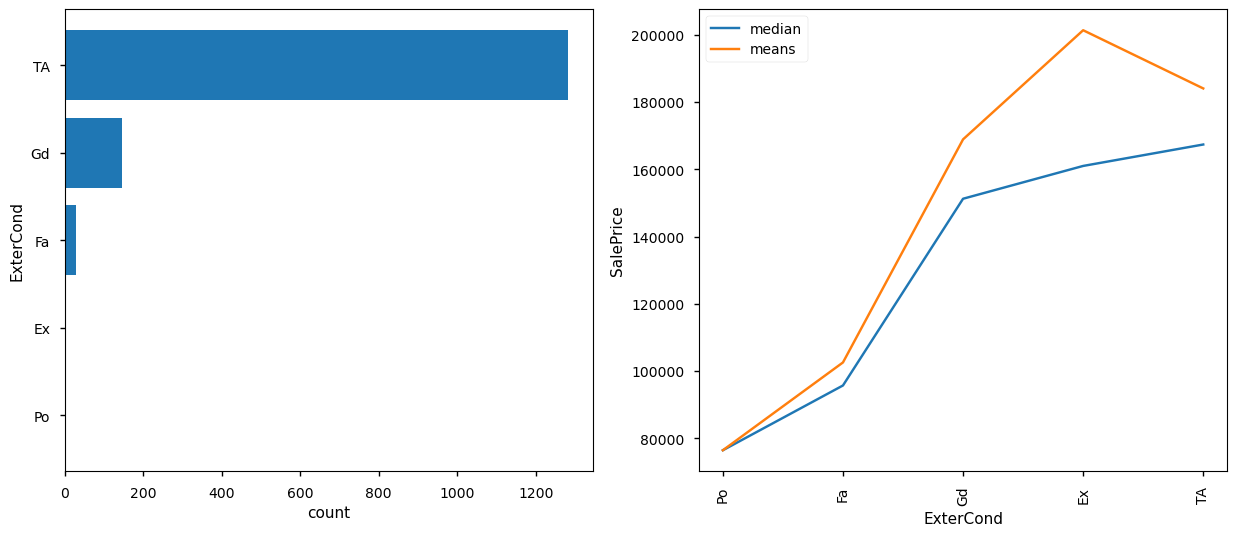

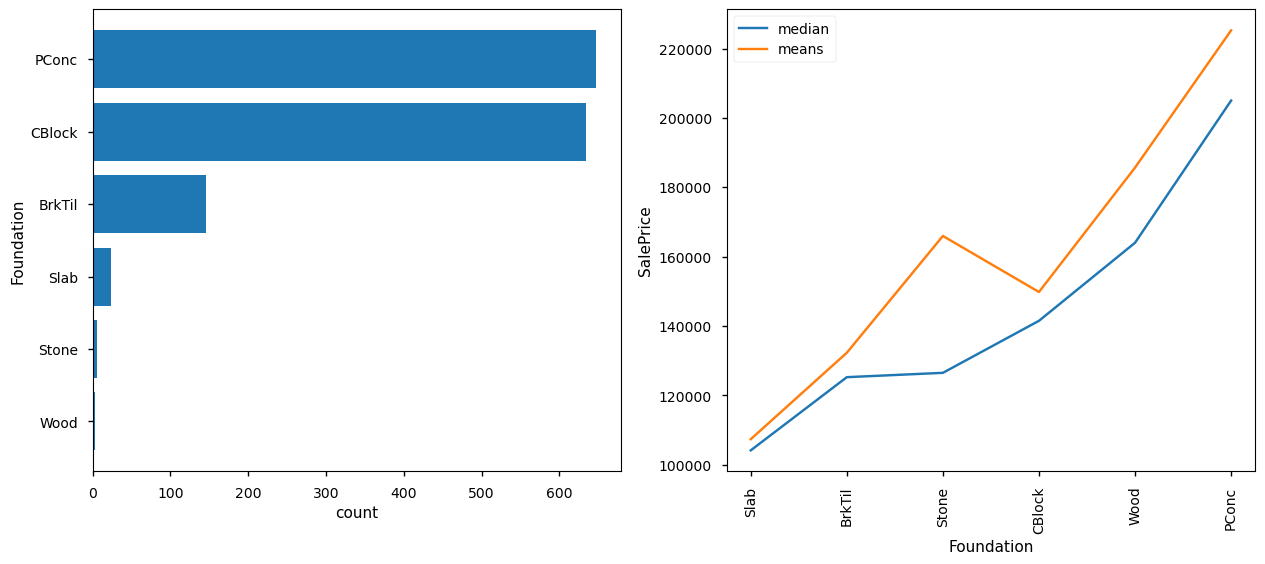

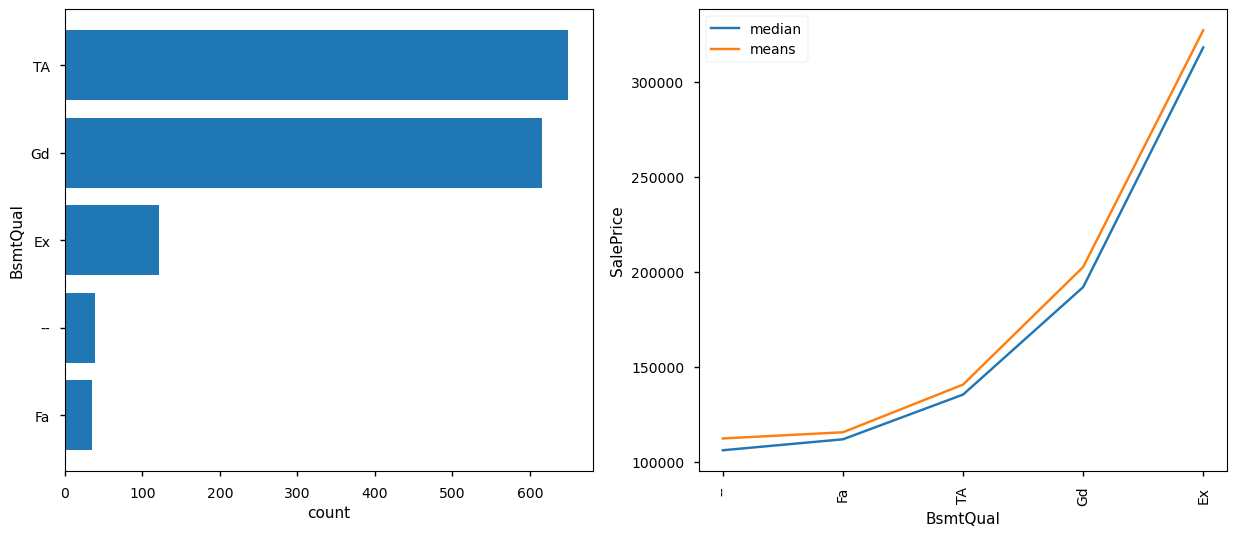

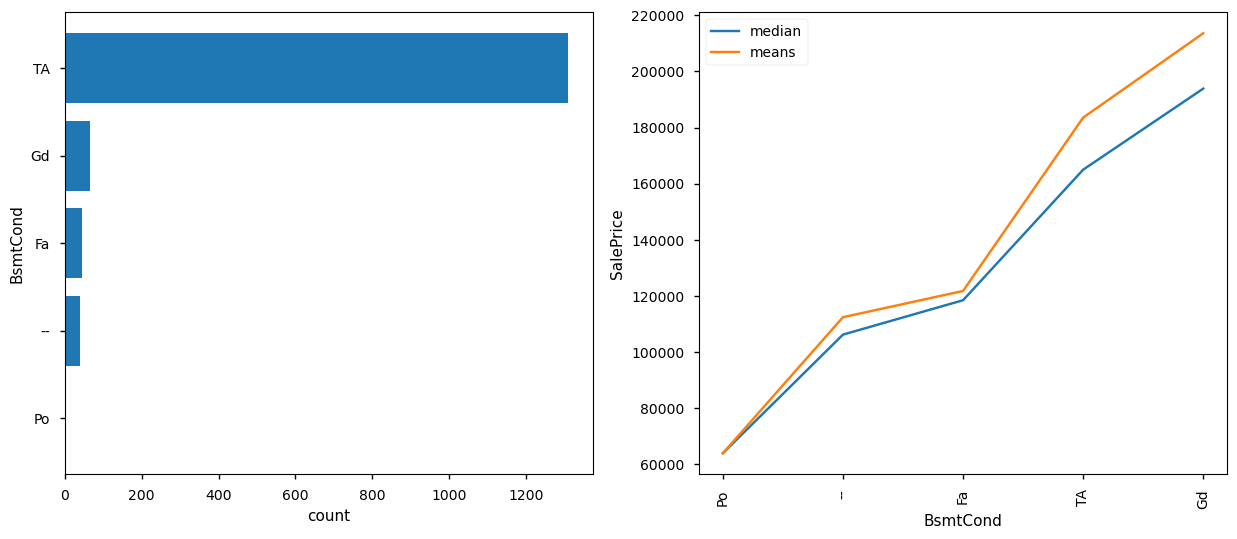

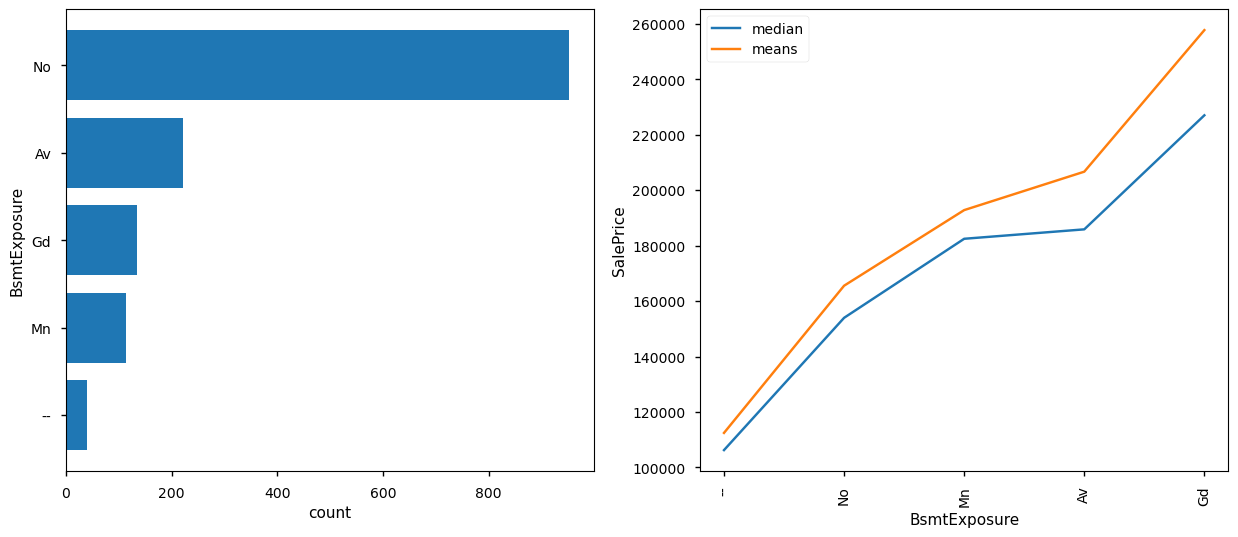

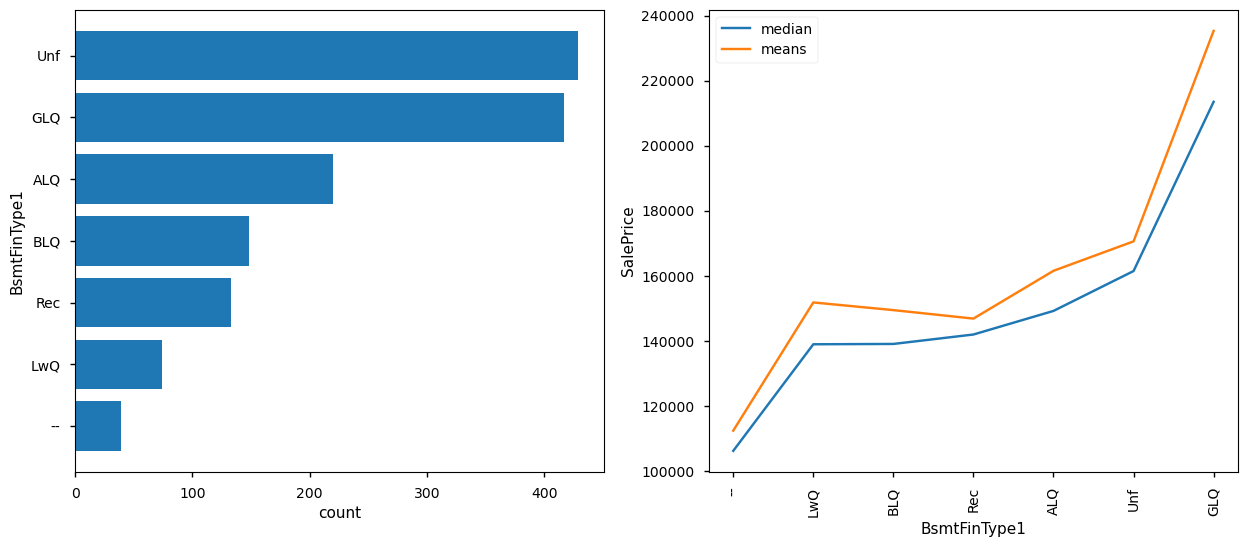

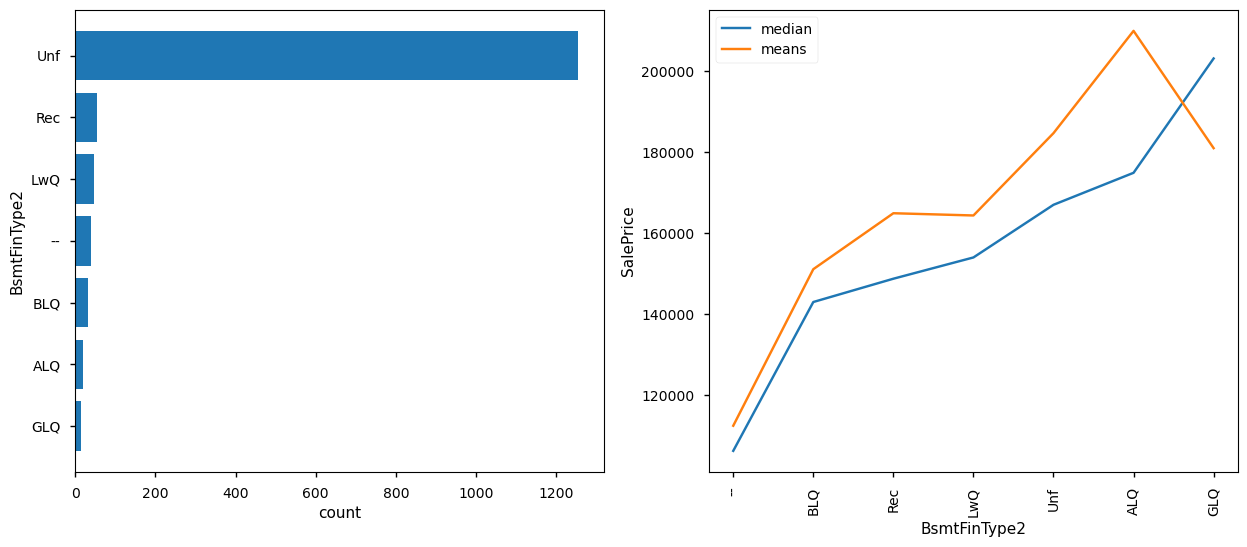

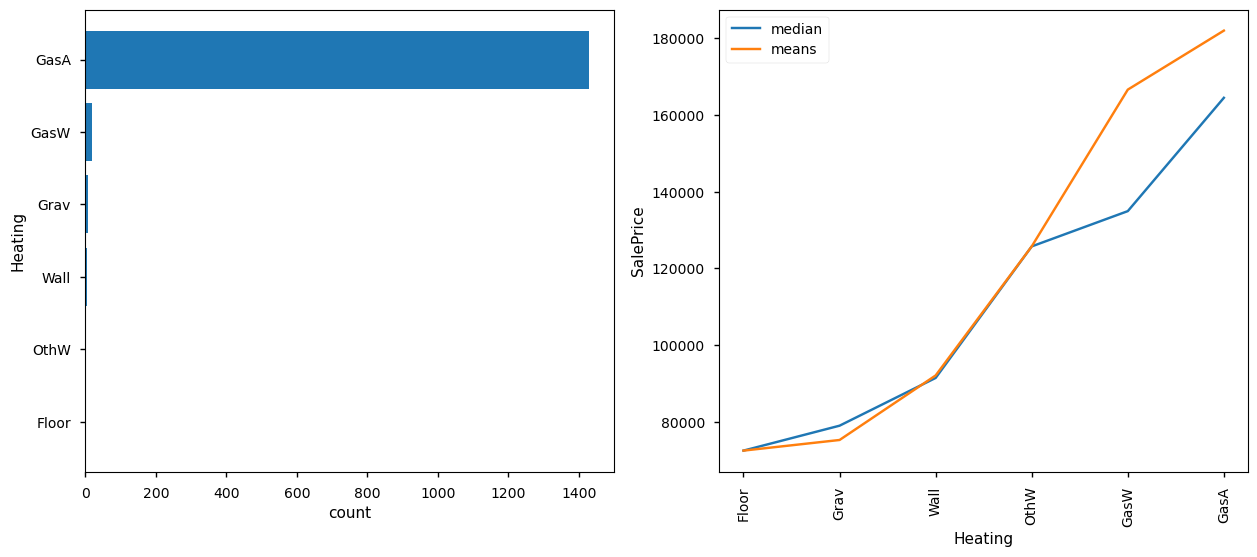

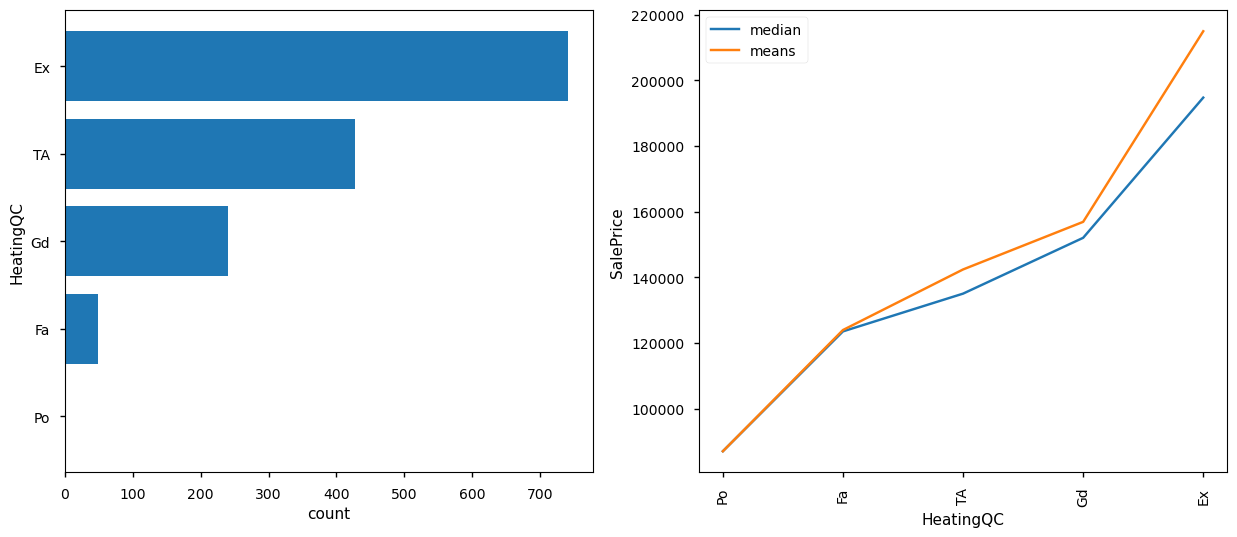

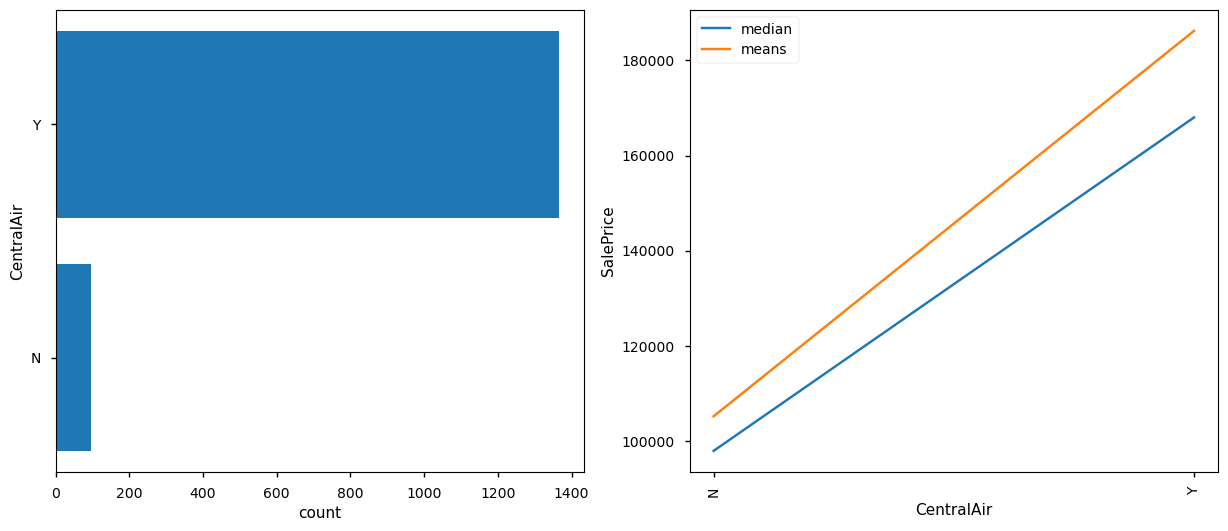

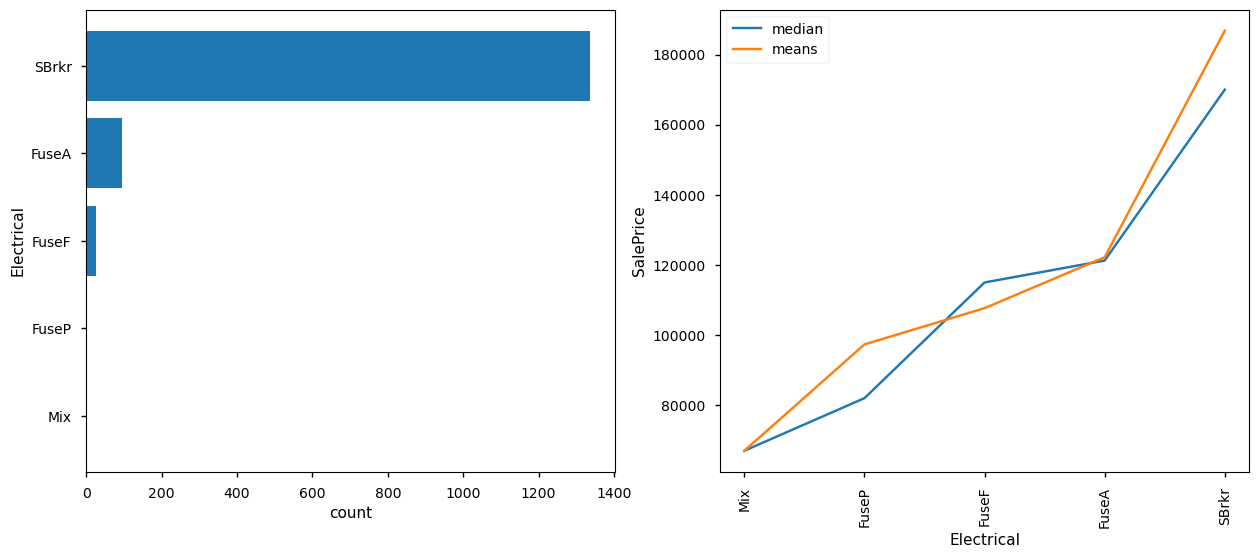

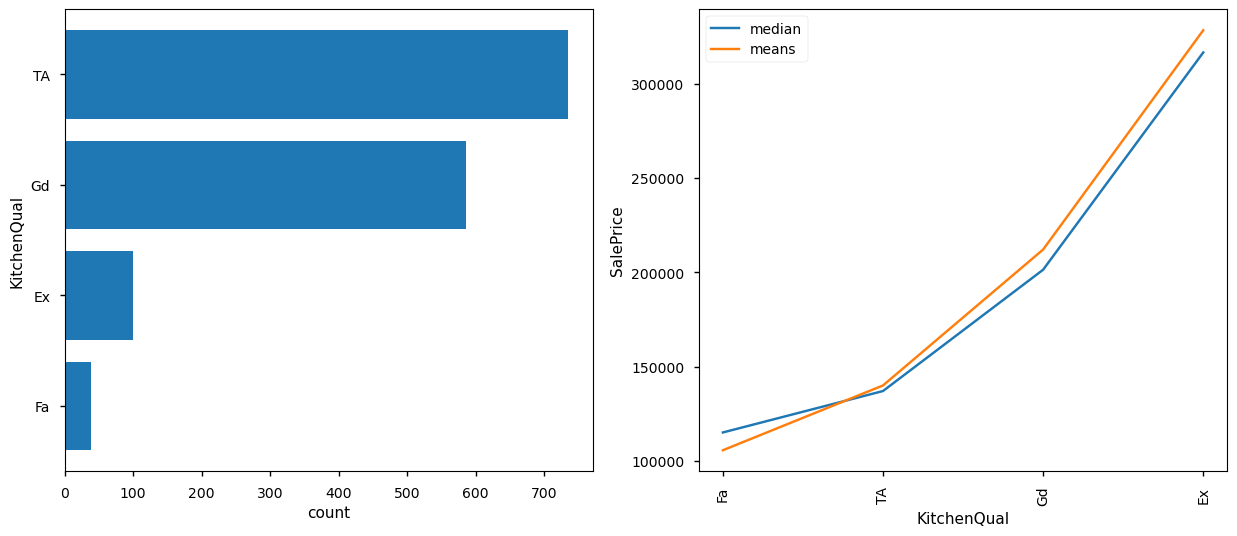

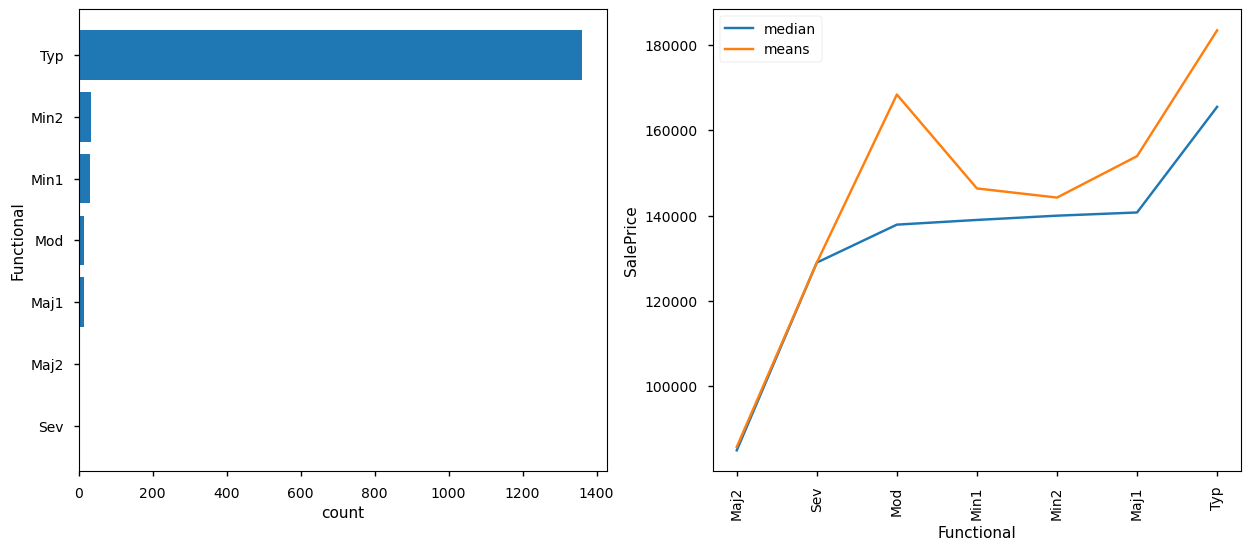

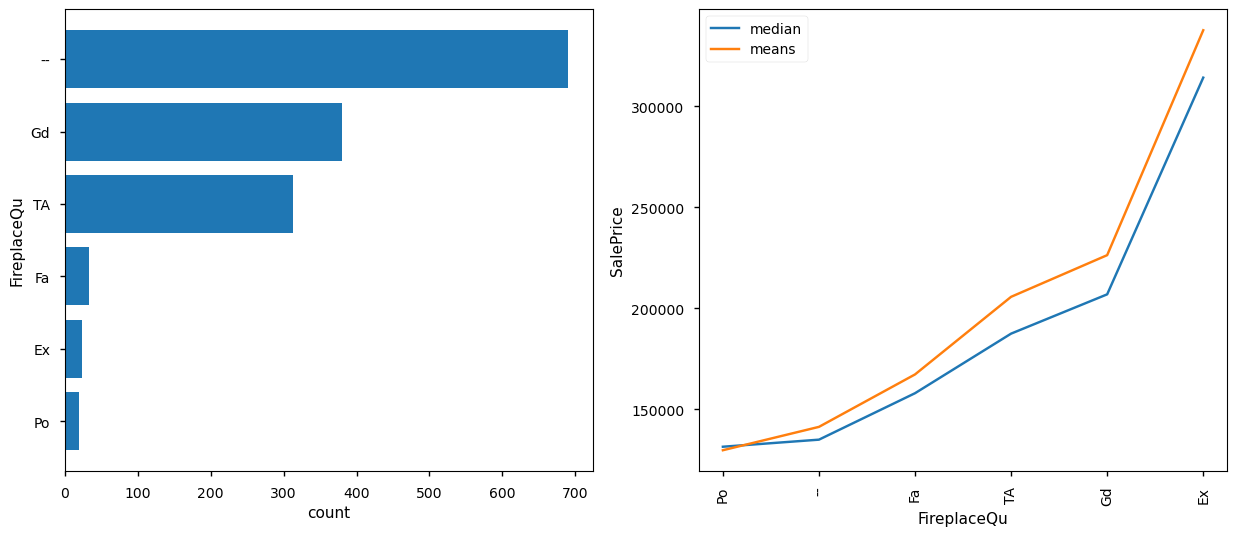

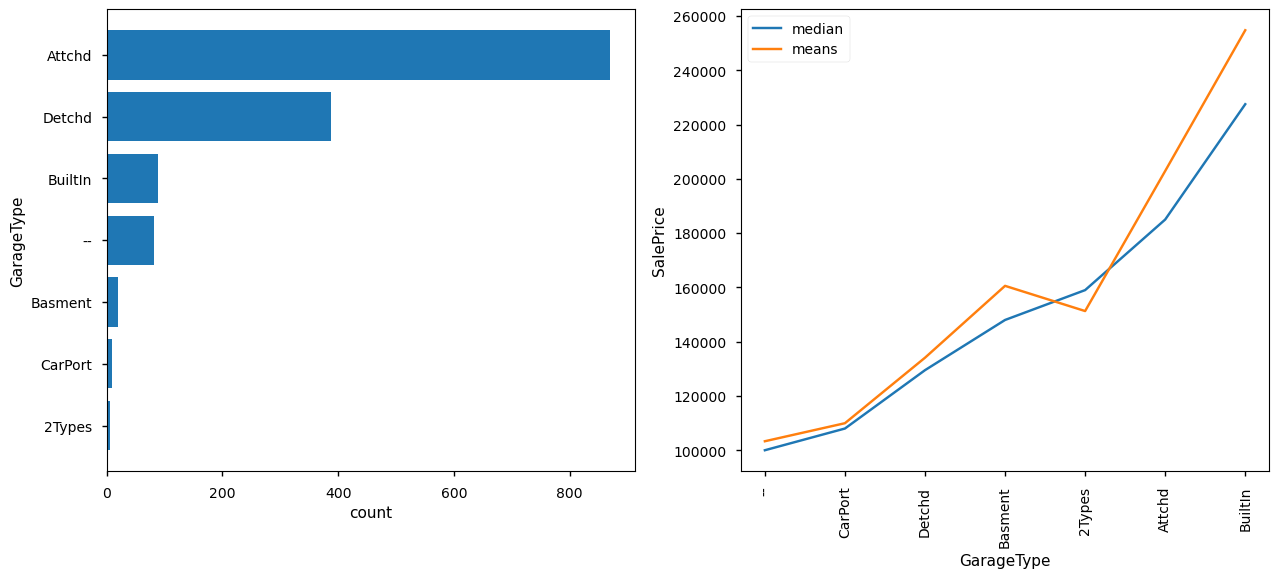

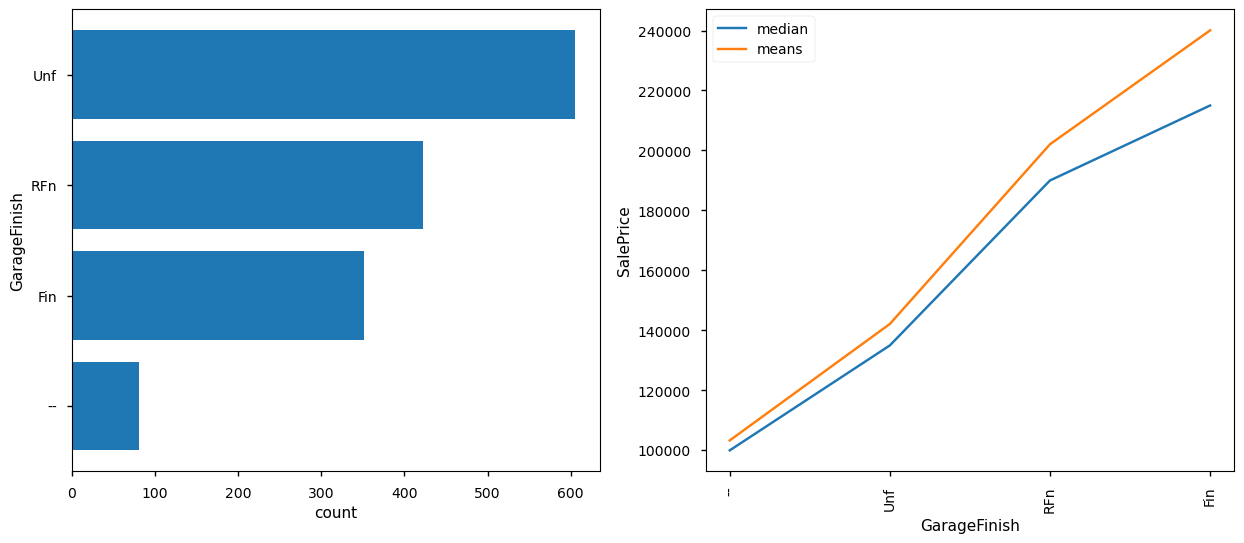

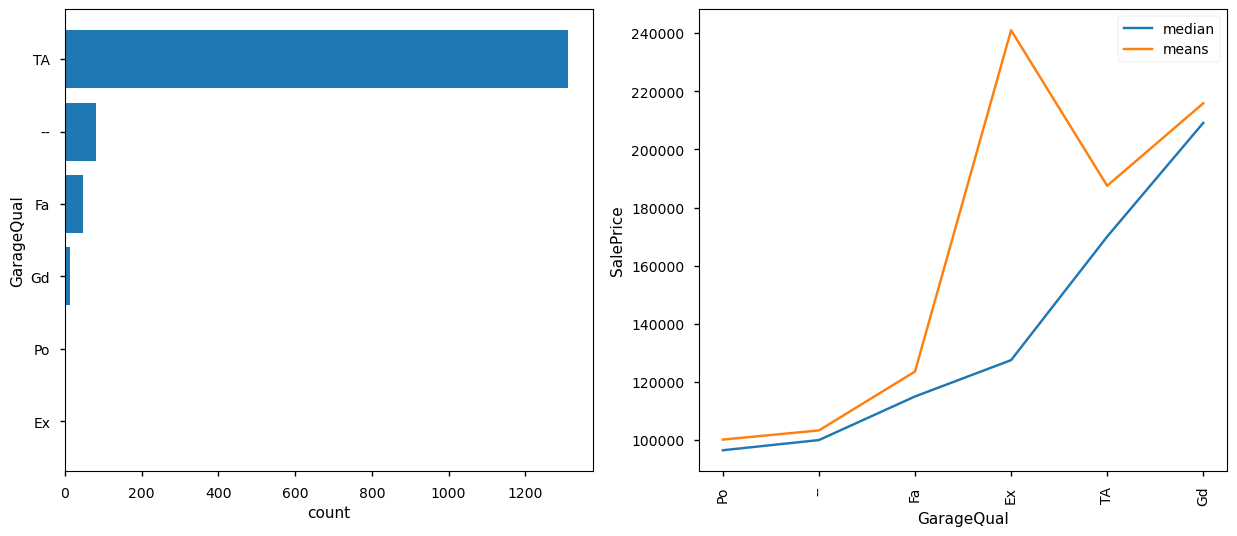

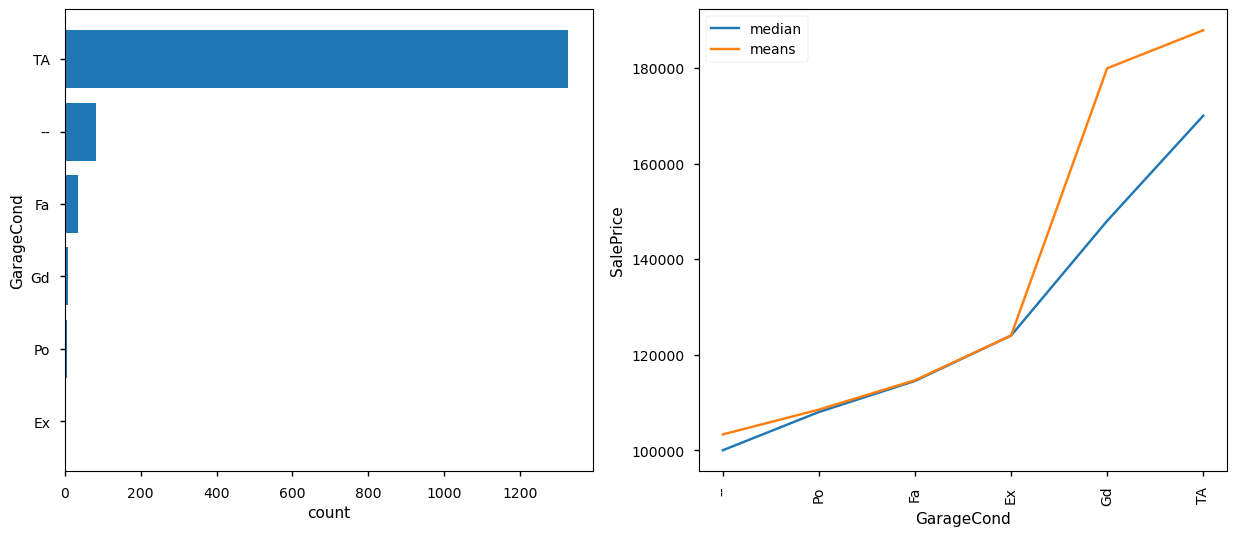

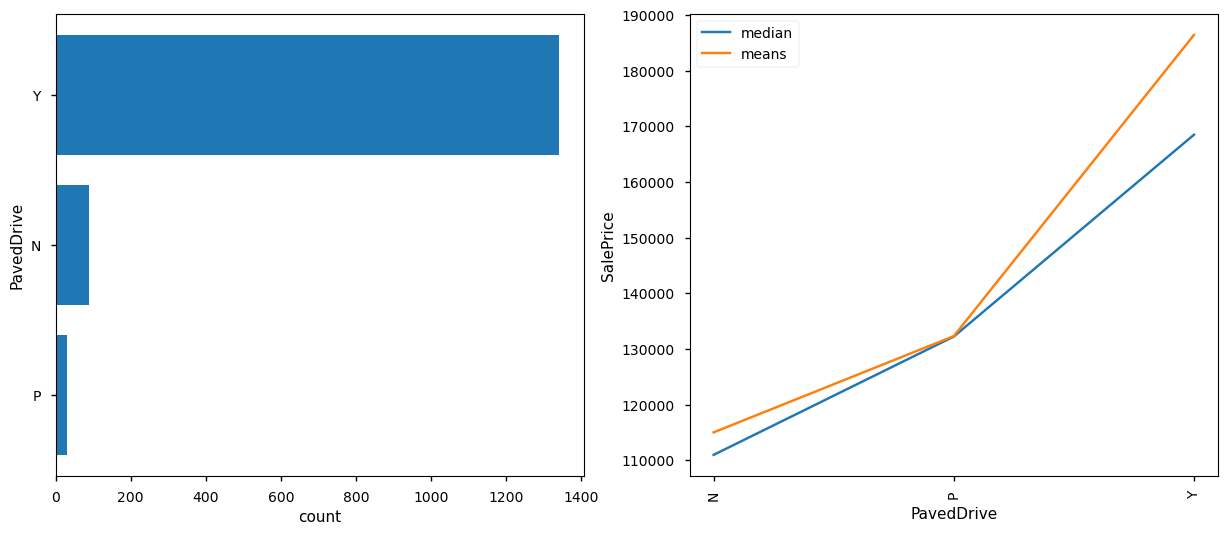

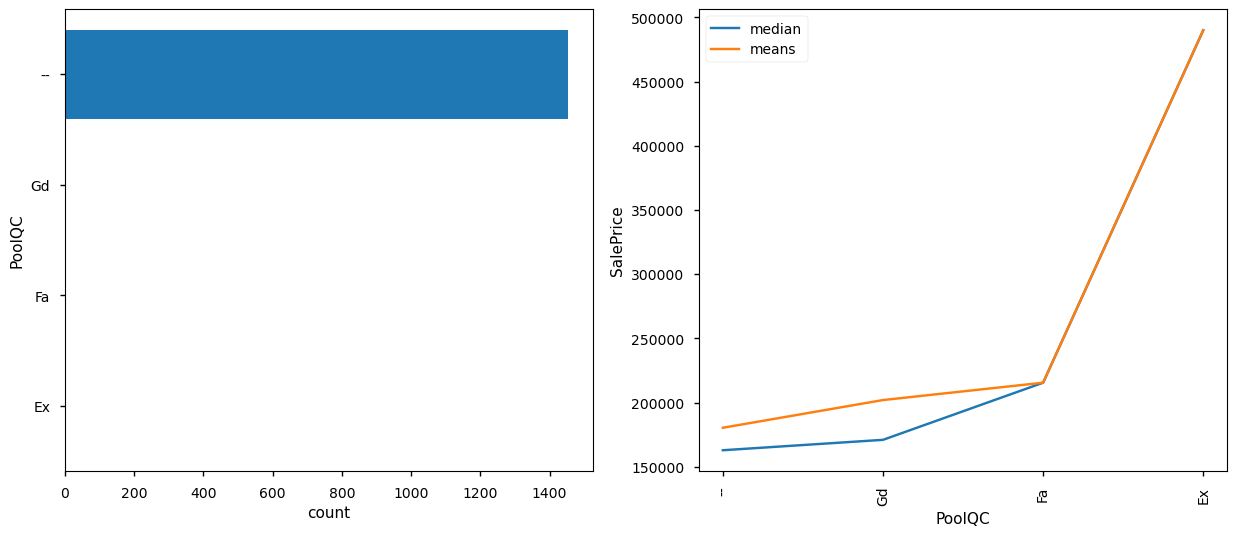

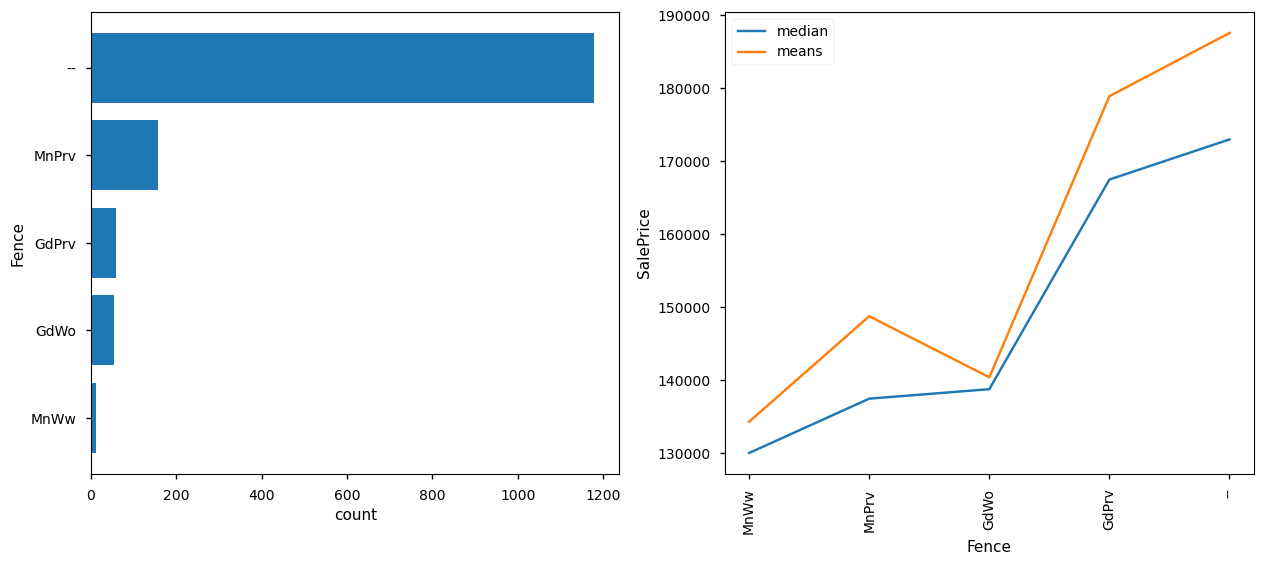

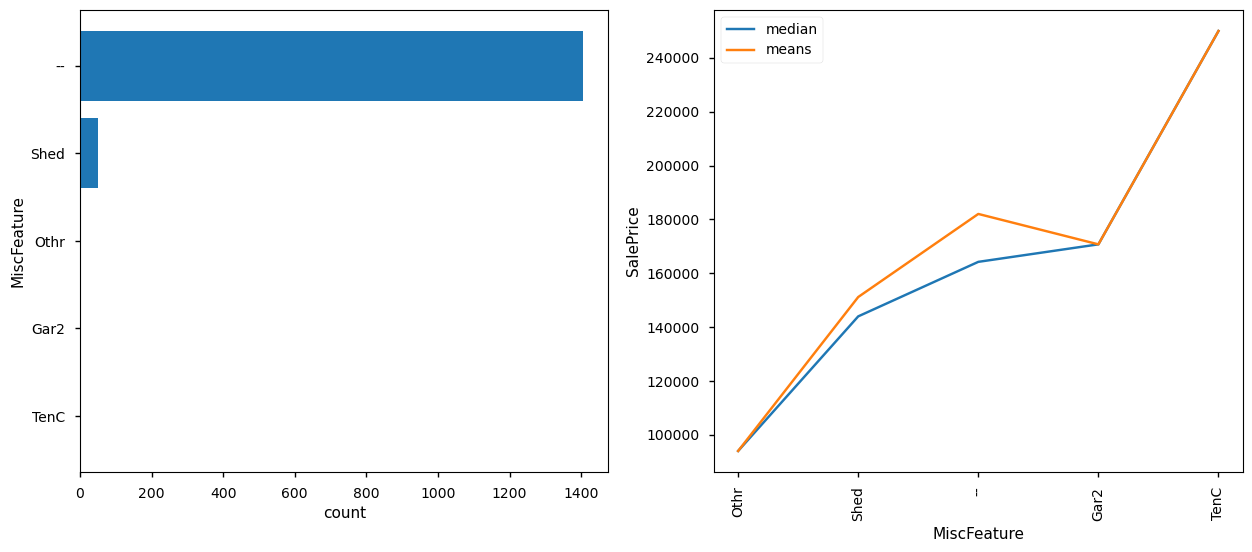

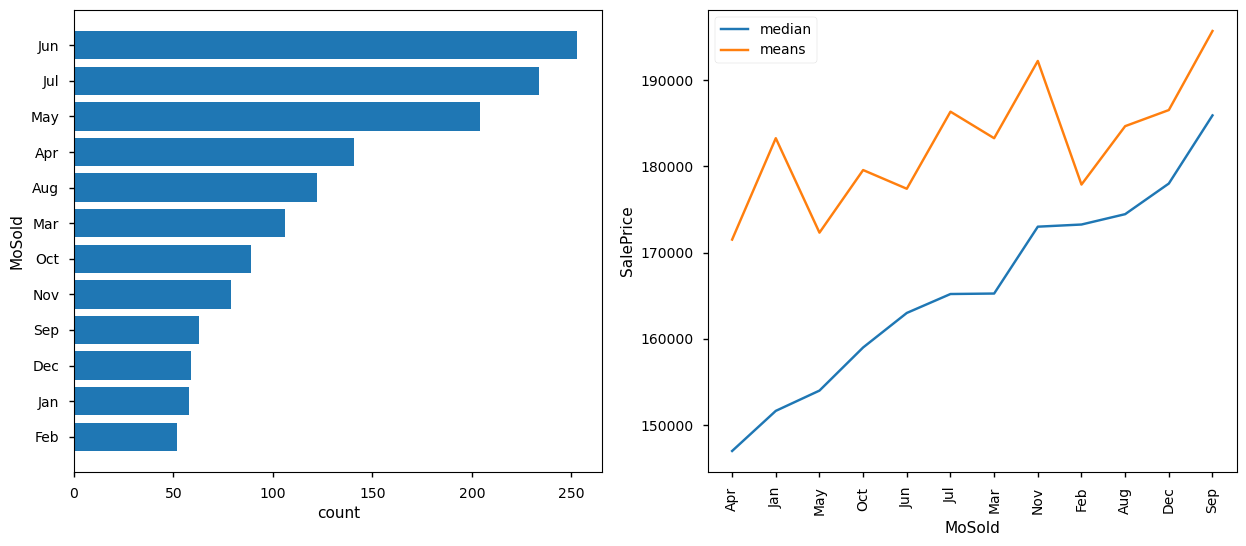

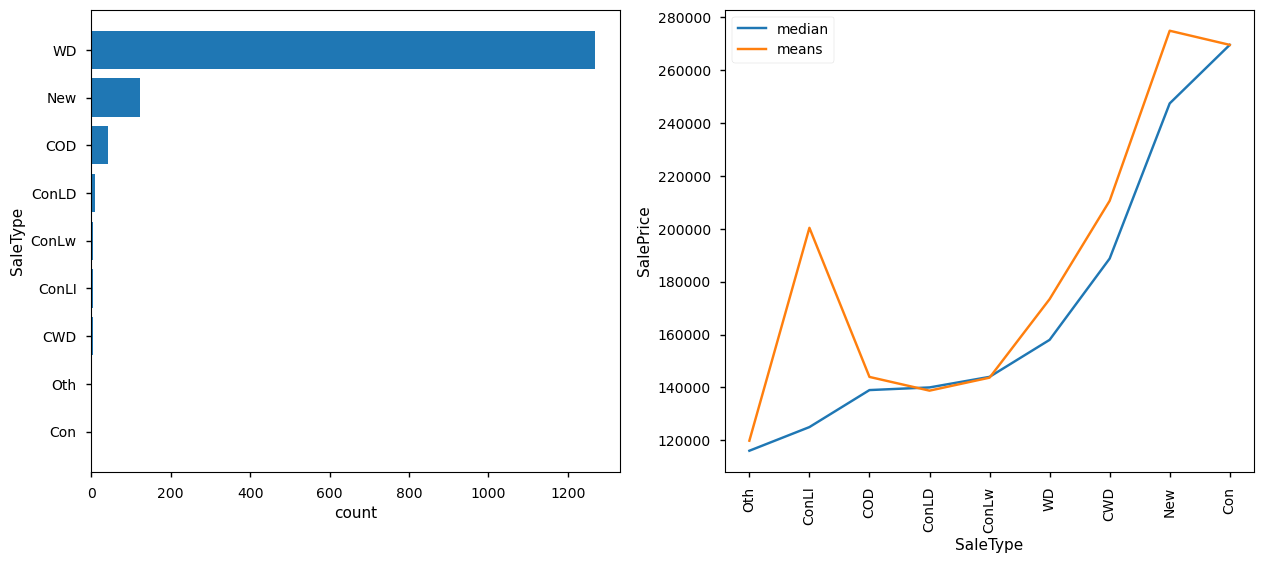

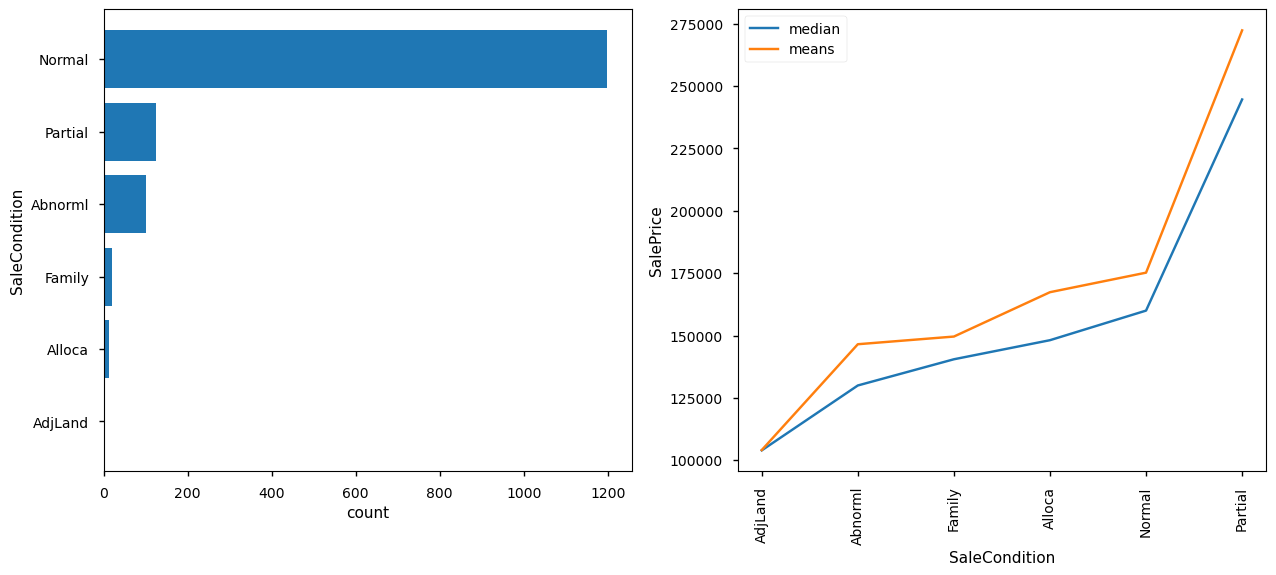

In [44]:
for col in cat_cols:
    
    medians, _ = CMMPlot(pd.concat([df5, target], axis=1), col, "SalePrice")
    
    encode_map = {col: {key: i for i, key in enumerate(medians.index)}}
    df5[col] = df5[col].map(encode_map[col])

# Scaling

In [45]:
scaler = StandardScaler()
df6 = pd.DataFrame(scaler.fit_transform(df5), index=df5.index, columns=df5.columns)
df6

MSSubClass  MSZoning  LotFrontage   LotArea    Street    Alley  \
0       1.212854  0.370133    -0.067206 -0.103719  0.064249  0.05533   
1       0.157538  0.370133     0.534836  0.146544  0.064249  0.05533   
2       1.212854  0.370133     0.063471  0.457629  0.064249  0.05533   
3      -0.106291  0.370133    -0.298801  0.136301  0.064249  0.05533   
4       1.212854  0.370133     0.676537  0.922662  0.064249  0.05533   
...          ...       ...          ...       ...       ...      ...   
2914   -0.370120 -2.063243    -3.296837 -2.993401  0.064249  0.05533   
2915   -0.370120 -2.063243    -3.296837 -3.036401  0.064249  0.05533   
2916    0.157538  0.370133     2.554304  1.586172  0.064249  0.05533   
2917   -0.897778  0.370133    -0.203962  0.311255  0.064249  0.05533   
2918    1.212854  0.370133     0.308591  0.152052  0.064249  0.05533   

      LotShape  LandContour  Utilities  LotConfig  LandSlope  Neighborhood  \
0    -0.656298    -0.133314   0.018512  -0.474733  -0.222018      0.637100   
1    -0.656298    -0.133314   0.018512   1.467447  -0.222018      1.081047   
2     0.903746    -0.133314   0.018512  -0.474733  -0.222018      0.637100   
3     0.903746    -0.133314   0.018512   0.496357  -0.222018      0.933065   
4     0.903746    -0.133314   0.018512   1.467447  -0.222018      1.672977   
...        ...          ...        ...        ...        ...           ...   
2914 -0.656298    -0.133314   0.018512  -0.474733  -0.222018     -1.730618   
2915 -0.656298    -0.133314   0.018512  -0.474733  -0.222018     -1.730618   
2916 -0.656298    -0.133314   0.018512  -0.474733  -0.222018     -0.102812   
2917 -0.656298    -0.133314   0.018512  -0.474733  -0.222018     -0.102812   
2918 -0.656298    -0.133314   0.018512  -0.474733   4.650690     -0.102812   

      Condition1  Condition2  BldgType  HouseStyle  OverallQual  OverallCond  \
0       0.122773     0.03971  0.140606    1.142208     0.646183    -0.435439   
1      -2.062445     0.03971  0.140606   -0.167596    -0.063185     1.906370   
2       0.122773     0.03971  0.140606    1.142208     0.646183    -0.435439   
3       0.122773     0.03971  0.140606    1.142208     0.646183    -0.435439   
4       0.122773     0.03971  0.140606    1.142208     1.355551    -0.435439   
...          ...         ...       ...         ...          ...          ...   
2914    0.122773     0.03971 -1.362797    1.142208    -1.481920     1.226101   
2915    0.122773     0.03971  1.644009    1.142208    -1.481920    -0.435439   
2916    0.122773     0.03971  0.140606   -0.167596    -0.772552     1.226101   
2917    0.122773     0.03971  0.140606   -0.822498    -0.772552    -0.435439   
2918    0.122773     0.03971  0.140606    1.142208     0.646183    -0.435439   

      RoofStyle  RoofMatl  Exterior1st  Exterior2nd  MasVnrType  MasVnrArea  \
0      -0.48138 -0.094062     0.965935     1.019577    0.815460    1.227704   
1      -0.48138 -0.094062    -0.958945    -1.033094   -0.699707   -0.790194   
2      -0.48138 -0.094062     0.965935     1.019577    0.815460    1.155343   
3      -0.48138 -0.094062    -1.343920    -1.261169   -0.699707   -0.790194   
4      -0.48138 -0.094062     0.965935     1.019577    0.815460    1.448310   
...         ...       ...          ...          ...         ...         ...   
2914   -0.48138 -0.094062     1.350910     1.247651   -0.699707   -0.790194   
2915   -0.48138 -0.094062     1.350910     1.247651   -0.699707   -0.790194   
2916   -0.48138 -0.094062     0.965935     1.019577   -0.699707   -0.790194   
2917   -0.48138 -0.094062    -0.188993    -1.261169   -0.699707   -0.790194   
2918   -0.48138 -0.094062    -0.188993    -0.120796    0.815460    0.949141   

      ExterQual  ExterCond  Foundation  BsmtQual  BsmtCond  BsmtExposure  \
0      1.039805   0.377654    0.973774  0.613251  0.128701     -0.579179   
1     -0.683756   0.377654   -0.448516  0.613251  0.128701      2.219865   
2      1.039805   0.377654    0.973774  0.613251  0.128701      0.

# Target Transformation

In [46]:
transformed_target = np.log(target)

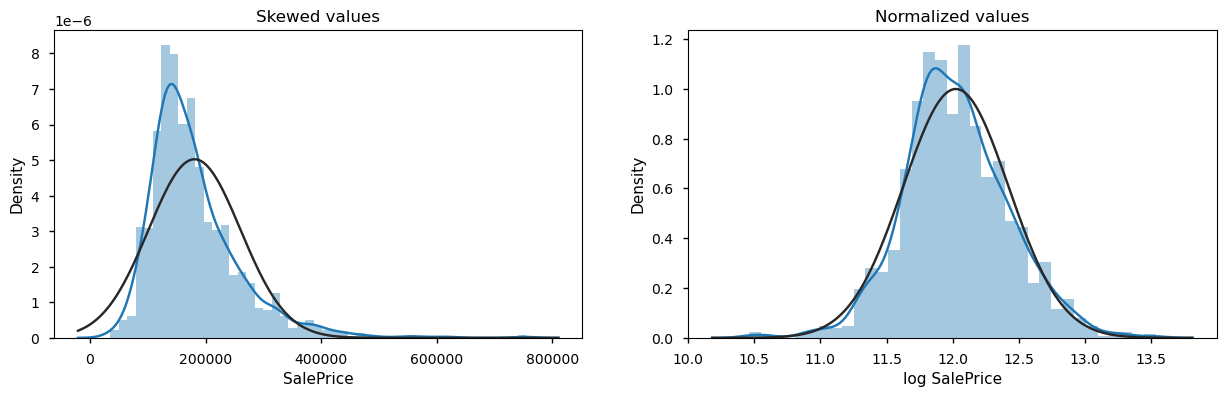

In [47]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 2)

plt.subplot(1, 2, 1)
sns.distplot(target, kde=True, fit=stats.norm)
plt.title("Skewed values")

plt.subplot(1, 2, 2)
sns.distplot(transformed_target, kde=True, fit=stats.norm)
plt.title("Normalized values")
plt.xlabel("log SalePrice")

plt.show()

# Splitting Train and Test Data

In [48]:
X_train = df6.loc[:len(train_df)-1]
X_test = df6.loc[len(train_df):]

In [49]:
X_train

MSSubClass  MSZoning  LotFrontage   LotArea    Street    Alley  \
0       1.212854  0.370133    -0.067206 -0.103719  0.064249  0.05533   
1       0.157538  0.370133     0.534836  0.146544  0.064249  0.05533   
2       1.212854  0.370133     0.063471  0.457629  0.064249  0.05533   
3      -0.106291  0.370133    -0.298801  0.136301  0.064249  0.05533   
4       1.212854  0.370133     0.676537  0.922662  0.064249  0.05533   
...          ...       ...          ...       ...       ...      ...   
1455    1.212854  0.370133    -0.203962 -0.231508  0.064249  0.05533   
1456    0.157538  0.370133     0.710921  0.767440  0.064249  0.05533   
1457   -0.106291  0.370133    -0.022998  0.029092  0.064249  0.05533   
1458    0.157538  0.370133     0.063471  0.170303  0.064249  0.05533   
1459    0.157538  0.370133     0.347528  0.214215  0.064249  0.05533   

      LotShape  LandContour  Utilities  LotConfig  LandSlope  Neighborhood  \
0    -0.656298    -0.133314   0.018512  -0.474733  -0.222018      0.637100   
1    -0.656298    -0.133314   0.018512   1.467447  -0.222018      1.081047   
2     0.903746    -0.133314   0.018512  -0.474733  -0.222018      0.637100   
3     0.903746    -0.133314   0.018512   0.496357  -0.222018      0.933065   
4     0.903746    -0.133314   0.018512   1.467447  -0.222018      1.672977   
...        ...          ...        ...        ...        ...           ...   
1455 -0.656298    -0.133314   0.018512  -0.474733  -0.222018      0.193153   
1456 -0.656298    -0.133314   0.018512  -0.474733  -0.222018      0.341135   
1457 -0.656298    -0.133314   0.018512  -0.474733  -0.222018      0.933065   
1458 -0.656298    -0.133314   0.018512  -0.474733  -0.222018     -0.398777   
1459 -0.656298    -0.133314   0.018512  -0.474733  -0.222018     -1.138689   

      Condition1  Condition2  BldgType  HouseStyle  OverallQual  OverallCond  \
0       0.122773     0.03971  0.140606    1.142208     0.646183    -0.435439   
1      -2.062445     0.03971  0.140606   -0.167596    -0.063185     1.906370   
2       0.122773     0.03971  0.140606    1.142208     0.646183    -0.435439   
3       0.122773     0.03971  0.140606    1.142208     0.646183    -0.435439   
4       0.122773     0.03971  0.140606    1.142208     1.355551    -0.435439   
...          ...         ...       ...         ...          ...          ...   
1455    0.122773     0.03971  0.140606    1.142208    -0.063185    -0.435439   
1456    0.122773     0.03971  0.140606   -0.167596    -0.063185     0.454875   
1457    0.122773     0.03971  0.140606    1.142208     0.646183     2.514892   
1458    0.122773     0.03971  0.140606   -0.167596    -0.772552     0.454875   
1459    0.122773     0.03971  0.140606   -0.167596    -0.772552     0.454875   

      RoofStyle  RoofMatl  Exterior1st  Exterior2nd  MasVnrType  MasVnrArea  \
0      -0.48138 -0.094062     0.965935     1.019577    0.815460    1.227704   
1      -0.48138 -0.094062    -0.958945    -1.033094   -0.699707   -0.790194   
2      -0.48138 -0.094062     0.965935     1.019577    0.815460    1.155343   
3      -0.48138 -0.094062    -1.343920    -1.261169   -0.699707   -0.790194   
4      -0.48138 -0.094062     0.965935     1.019577    0.815460    1.448310   
...         ...       ...          ...          ...         ...         ...   
1455   -0.48138 -0.094062     0.965935     1.019577   -0.699707   -0.790194   
1456   -0.48138 -0.094062     0.580959     0.335353    2.330626    1.038369   
1457   -0.48138 -0.094062     1.350910     1.247651   -0.699707   -0.790194   
1458    1.91853 -0.094062    -0.958945    -1.033094   -0.699707   -0.790194   
1459   -0.48138 -0.094062    -0.188993    -0.120796   -0.699707   -0.790194   

      ExterQual  ExterCond  Foundation  BsmtQual  BsmtCond  BsmtExposure  \
0      1.039805   0.377654    0.973774  0.613251  0.128701     -0.579179   
1     -0.683756   0.377654   -0.448516  0.613251  0.128701      2.219865   
2      1.039805   0.377654    0.973774  0.613251  0.128701      0.

In [50]:
X_test

MSSubClass  MSZoning  LotFrontage   LotArea    Street    Alley  \
1460    0.157538 -0.846555     0.534836  0.521437  0.064249  0.05533   
1461    0.157538  0.370133     0.570907  0.923625  0.064249  0.05533   
1462    1.212854  0.370133     0.308591  0.862607  0.064249  0.05533   
1463    1.212854  0.370133     0.461339  0.222291  0.064249  0.05533   
1464    0.949025  0.370133    -1.259167 -1.130892  0.064249  0.05533   
...          ...       ...          ...       ...       ...      ...   
2914   -0.370120 -2.063243    -3.296837 -2.993401  0.064249  0.05533   
2915   -0.370120 -2.063243    -3.296837 -3.036401  0.064249  0.05533   
2916    0.157538  0.370133     2.554304  1.586172  0.064249  0.05533   
2917   -0.897778  0.370133    -0.203962  0.311255  0.064249  0.05533   
2918    1.212854  0.370133     0.308591  0.152052  0.064249  0.05533   

      LotShape  LandContour  Utilities  LotConfig  LandSlope  Neighborhood  \
1460 -0.656298    -0.133314   0.018512  -0.474733  -0.222018     -0.398777   
1461  0.903746    -0.133314   0.018512   0.496357  -0.222018     -0.398777   
1462  0.903746    -0.133314   0.018512  -0.474733  -0.222018      0.193153   
1463  0.903746    -0.133314   0.018512  -0.474733  -0.222018      0.193153   
1464  0.903746     4.119631   0.018512  -0.474733  -0.222018      1.524994   
...        ...          ...        ...        ...        ...           ...   
2914 -0.656298    -0.133314   0.018512  -0.474733  -0.222018     -1.730618   
2915 -0.656298    -0.133314   0.018512  -0.474733  -0.222018     -1.730618   
2916 -0.656298    -0.133314   0.018512  -0.474733  -0.222018     -0.102812   
2917 -0.656298    -0.133314   0.018512  -0.474733  -0.222018     -0.102812   
2918 -0.656298    -0.133314   0.018512  -0.474733   4.650690     -0.102812   

      Condition1  Condition2  BldgType  HouseStyle  OverallQual  OverallCond  \
1460   -2.062445     0.03971  0.140606   -0.167596    -0.772552     0.454875   
1461    0.122773     0.03971  0.140606   -0.167596    -0.063185     0.454875   
1462    0.122773     0.03971  0.140606    1.142208    -0.772552    -0.435439   
1463    0.122773     0.03971  0.140606    1.142208    -0.063185     0.454875   
1464    0.122773     0.03971  1.644009   -0.167596     1.355551    -0.435439   
...          ...         ...       ...         ...          ...          ...   
2914    0.122773     0.03971 -1.362797    1.142208    -1.481920     1.226101   
2915    0.122773     0.03971  1.644009    1.142208    -1.481920    -0.435439   
2916    0.122773     0.03971  0.140606   -0.167596    -0.772552     1.226101   
2917    0.122773     0.03971  0.140606   -0.822498    -0.772552    -0.435439   
2918    0.122773     0.03971  0.140606    1.142208     0.646183    -0.435439   

      RoofStyle  RoofMatl  Exterior1st  Exterior2nd  MasVnrType  MasVnrArea  \
1460   -0.48138 -0.094062     0.965935     1.019577   -0.699707   -0.790194   
1461    1.91853 -0.094062    -1.343920    -1.489243    0.815460    1.001647   
1462   -0.48138 -0.094062     0.965935     1.019577   -0.699707   -0.790194   
1463   -0.48138 -0.094062     0.965935     1.019577    0.815460    0.372649   
1464   -0.48138 -0.094062    -0.188993    -0.120796   -0.699707   -0.790194   
...         ...       ...          ...          ...         ...         ...   
2914   -0.48138 -0.094062     1.350910     1.247651   -0.699707   -0.790194   
2915   -0.48138 -0.094062     1.350910     1.247651   -0.699707   -0.790194   
2916   -0.48138 -0.094062     0.965935     1.019577   -0.699707   -0.790194   
2917   -0.48138 -0.094062    -0.188993    -1.261169   -0.699707   -0.790194   
2918   -0.48138 -0.094062    -0.188993    -0.120796    0.815460    0.949141   

      ExterQual  ExterCond  Foundation  BsmtQual  BsmtCond  BsmtExposure  \
1460  -0.683756   0.377654   -0.448516 -0.610317  0.128701     -0.579179   
1461  -0.683756   0.377654   -0.448516 -0.610317  0.128701     -0.579179   
1462  -0.683756   0.377654    0.973774  0.613251  0.128701     -0.

# Bagging Ensembling

We'll train 5 different models and take a weighted average as the final result.

In [70]:
models = {
    "catboost": CatBoostRegressor(verbose=10),
    "br": BayesianRidge(),
    "xgb": XGBRegressor(),
    "lgbm": LGBMRegressor(),
    "ridge": Ridge()
}

In [71]:
for name, model in models.items():
    model.fit(X_train, transformed_target)
    print(name, " trained")

Learning rate set to 0.043466
0:	learn: 0.3878703	total: 4.91ms	remaining: 4.91s
10:	learn: 0.2990906	total: 51.3ms	remaining: 4.61s
20:	learn: 0.2383032	total: 87.1ms	remaining: 4.06s
30:	learn: 0.1981962	total: 132ms	remaining: 4.13s
40:	learn: 0.1706287	total: 171ms	remaining: 4.01s
50:	learn: 0.1521634	total: 208ms	remaining: 3.87s
60:	learn: 0.1388195	total: 249ms	remaining: 3.84s
70:	learn: 0.1300407	total: 284ms	remaining: 3.71s
80:	learn: 0.1231214	total: 317ms	remaining: 3.6s
90:	learn: 0.1180463	total: 349ms	remaining: 3.48s
100:	learn: 0.1137131	total: 385ms	remaining: 3.42s
110:	learn: 0.1102877	total: 425ms	remaining: 3.4s
120:	learn: 0.1073291	total: 463ms	remaining: 3.36s
130:	learn: 0.1046324	total: 493ms	remaining: 3.27s
140:	learn: 0.1021777	total: 523ms	remaining: 3.18s
150:	learn: 0.1000745	total: 548ms	remaining: 3.08s
160:	learn: 0.0981419	total: 579ms	remaining: 3.01s
170:	learn: 0.0964388	total: 607ms	remaining: 2.94s
180:	learn: 0.0947614	total: 639ms	remaining

# Evaluation

In [72]:
results = {}

kf = KFold(n_splits=30)

for name, model in models.items():
    res = np.exp(np.sqrt(-cross_val_score(model, X_train, transformed_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = np.mean(res)

Learning rate set to 0.043232
0:	learn: 0.3862398	total: 4.17ms	remaining: 4.16s
10:	learn: 0.2982388	total: 48.9ms	remaining: 4.4s
20:	learn: 0.2379610	total: 83.1ms	remaining: 3.87s
30:	learn: 0.1977199	total: 123ms	remaining: 3.85s
40:	learn: 0.1701971	total: 157ms	remaining: 3.67s
50:	learn: 0.1512509	total: 191ms	remaining: 3.55s
60:	learn: 0.1381113	total: 229ms	remaining: 3.53s
70:	learn: 0.1287645	total: 276ms	remaining: 3.61s
80:	learn: 0.1223400	total: 310ms	remaining: 3.52s
90:	learn: 0.1167713	total: 344ms	remaining: 3.44s
100:	learn: 0.1125752	total: 377ms	remaining: 3.35s
110:	learn: 0.1090250	total: 412ms	remaining: 3.3s
120:	learn: 0.1062430	total: 450ms	remaining: 3.27s
130:	learn: 0.1039200	total: 483ms	remaining: 3.2s
140:	learn: 0.1017684	total: 520ms	remaining: 3.17s
150:	learn: 0.0998887	total: 553ms	remaining: 3.11s
160:	learn: 0.0979583	total: 586ms	remaining: 3.05s
170:	learn: 0.0964542	total: 617ms	remaining: 2.99s
180:	learn: 0.0949363	total: 648ms	remaining:

In [64]:
for name, res in results.items():
    print(name, "mean error:", res)

catboost mean error: 1.1256527444390305
br mean error: 1.137266399757936
xgb mean error: 1.149199583322769
lgbm mean error: 1.1363996296892172
ridge mean error: 1.1390180526853477


In [65]:
np.max(target), np.min(target)

(755000, 34900)

The error values are remarkably small compared to the _'SalePrice'_ range (34900, 755000). Great results!!

The __catboost__ model outperforms other models by a large margin. By ranking the models based on their __MSE__ values, we can assign befitting weights to each for bagging:
1. catboost
2. lgbm
3. br
4. ridge
5. xgb

# Prediction

In [66]:
preds = {}

for name, model in models.items():
    preds.update({name: np.exp(model.predict(X_test))})

After few trials, this weighted average produced the best result, scoring 0.12035 and placing 165 among 4106 participants.

In [67]:
y_pred = (
            .4 * preds["catboost"] +
            .175 * preds["lgbm"] +
            .325 * preds["br"] +
            .075 * preds["ridge"] +
            .025 * preds["xgb"]
)

In [68]:
output = pd.DataFrame({'Id': test_ids,
                       'SalePrice': y_pred.squeeze()})

output

Id      SalePrice
0     1461  122400.618507
1     1462  160099.628780
2     1463  181553.859463
3     1464  195333.914191
4     1465  197009.152393
...    ...            ...
1454  2915   84538.732871
1455  2916   81751.391708
1456  2917  158379.961762
1457  2918  117966.007109
1458  2919  216471.769770

[1459 rows x 2 columns]

In [60]:
output.to_csv('./submission.csv', index=False)